In [7]:
# from whole_brain_model import WholeBrainModel, ModelParams
# from model_fitting import ModelFitting
# from costs import Costs

In [7]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

### Plotter

In [8]:
class Plotter:
    @staticmethod
    def plot_loss_curve(epoch_indices, loss_values):
        plt.figure()
        plt.plot(epoch_indices, loss_values, marker='o')
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    @staticmethod
    def plot_rmse_curve(epoch_indices, rmse_values):
        plt.figure()
        plt.plot(epoch_indices, rmse_values, marker='o')
        plt.title("RMSE over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("RMSE")
        plt.show()

    @staticmethod
    def plot_roi_correlation_curve(epoch_indices, roi_corr_values):
        plt.figure()
        plt.plot(epoch_indices, roi_corr_values, marker='o')
        plt.title("Average ROI Correlation over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Average ROI Pearson r")
        plt.show()

    @staticmethod
    def plot_fc_correlation_curve(epoch_indices, fc_corr_values):
        plt.figure()
        plt.plot(epoch_indices, fc_corr_values, marker='o')
        plt.title("Average FC Correlation over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Average FC Pearson r")
        plt.show()

    @staticmethod
    def plot_functional_connectivity_heatmaps(simulated_fc: np.ndarray, empirical_fc: np.ndarray):
        """
            Plots both simulated and empirical Functional Connectivity (heatmap) on horizontal axis
            sim_fc, emp_fc: np.ndarray
        """
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        sns.heatmap(simulated_fc, vmin=-1, vmax=1, cmap='coolwarm', ax=axes[0])
        axes[0].set_title("Simulated FC")
        sns.heatmap(empirical_fc, vmin=-1, vmax=1, cmap='coolwarm', ax=axes[1])
        axes[1].set_title("Empirical FC")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_time_series(time_series: torch.Tensor, title: str, max_nodes: int = 6):
        """
            Plots batched BOLD time series on single plot:
            time_series: torch.Tensor, shape (N, T, B)
        """
        data = time_series.detach().cpu().numpy() if isinstance(time_series, torch.Tensor) else time_series
        N, T, B = data.shape
        for batch_idx in range(B):
            plt.figure(figsize=(10, 4))
            for node_idx in range(min(N, max_nodes)):
                plt.plot(np.arange(T), data[node_idx, :, batch_idx], label=f"Node {node_idx}")
            plt.title(f"{title} (Batch {batch_idx})")
            plt.xlabel("TR")
            plt.ylabel("BOLD signal")
            plt.legend()
            plt.show()

    @staticmethod
    def plot_hidden_states(hidden_state_logs: np.ndarray, state_names = ['E', 'I', 'x', 'f', 'v', 'q']):
        """
            hidden_state_logs: list of `epoch` elements, each (time_points, state_size = 6)
            Heatmaps each of six state variables (E, I, x, f, v, q) over TRs, where colour is the state value
        """
        logs = np.stack(hidden_state_logs, axis=0)
        num_epochs, T, state_size = logs.shape

        for dim in range(state_size):
            plt.figure(figsize=(6, 4))
            sns.heatmap(logs[:, :, dim], xticklabels=max(1, T//10), yticklabels=1, cmap="magma", cbar_kws={'label': state_names[dim]})
            plt.title(f"Evolution of hidden-state '{state_names[dim]}'")
            plt.xlabel("TR")
            plt.ylabel("Epoch")
            plt.tight_layout()
            plt.show()


    @staticmethod
    def plot_coupling_parameters(parameter_history):
        """
            parameter_history: dictionary of `epoch` elements each (time_points, parameter_size = 4)
            Plots each of the four core coupling parameters (g, g_EE, g_EI, g_IE)
        """
        plt.figure(figsize=(6, 4))
        for param_name, values in parameter_history.items():            
            epochs = range(1, len(values) + 1)
            plt.plot(epochs, values, marker='o', label=param_name)
        plt.title("Coupling parameters over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Parameter Value")
        plt.legend()
        plt.tight_layout()
        plt.show()
        

    @staticmethod
    def plot_node_comparison(empirical_bold: torch.Tensor, simulated_bold: torch.Tensor, node_indices=None):
        if node_indices is None:
            node_indices = list(range(min(6, empirical_bold.shape[0])))
        emp = empirical_bold.detach().cpu().numpy()
        sim = simulated_bold.detach().cpu().numpy()
        T = emp.shape[1]
        fig, axes = plt.subplots(len(node_indices), 1, figsize=(10, 2*len(node_indices)), sharex=True)
        for i, node in enumerate(node_indices):
            axes[i].plot(np.arange(T), emp[node, :, 0], label="Empirical")
            axes[i].plot(np.arange(T), sim[node, :, 0], label="Simulated")
            axes[i].set_ylabel(f"Node {node}")
            if i == 0:
                axes[i].legend()
        axes[-1].set_xlabel("TR")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_laplacian(subject_index: int, laplacian_matrix: np.ndarray):
        plt.figure(figsize=(6, 5))
        sns.heatmap(laplacian_matrix, cmap='viridis')
        plt.title(f"Laplacian Heatmap (Subject {subject_index})")
        plt.xlabel("Node")
        plt.ylabel("Node")
        plt.show()

    @staticmethod
    def plot_distance_matrix(subject_index: int, distance_matrix: np.ndarray):
        plt.figure(figsize=(6, 5))
        sns.heatmap(distance_matrix, cmap='magma')
        plt.title(f"Distance Matrix (Subject {subject_index})")
        plt.xlabel("Node")
        plt.ylabel("Node")
        plt.show()

### Data Loader

In [84]:
class DataLoader:
    def __init__(self, fmri_filename: str, dti_filename: str, distance_matrices_path: str, chunk_length: int = 50):
        """
        Loads fMRI (BOLD) time series, Structural Connectivity matrices, and distance (delay) matrices, and splits BOLD time series into chunks
        """
        self.fmri_filename = fmri_filename
        self.dti_filename = dti_filename
        self.distance_matrices_path = distance_matrices_path
        self.chunk_length = chunk_length
        self.all_bold = []      # list of BOLD arrays, each shape (node_size, num_TRs)
        self.all_SC = []        # list of SC matrices, each shape (node_size, node_size)
        self.all_distances = [] # list of dist_matrix, each shape (node_size, node_size)
        self.bold_chunks = []   # list of dicts: {'subject': int, 'bold': array (node_size, chunk_length)}
        
        self._load_data()
        self._split_into_chunks()

    def get_node_size(self):
        if len(self.all_SC) == 0: 
            return 0
        return self.all_SC[0].shape[0]

    def _load_data(self):
        fmri_mat = scipy.io.loadmat(self.fmri_filename)
        bold_data = fmri_mat["BOLD_timeseries_HCP"]    # shape (100, 1)
        # dti_mat = scipy.io.loadmat(self.dti_filename)
        # dti_data = dti_mat["DTI_fibers_HCP"]           # shape (100, 1)
        num_subjects = bold_data.shape[0]
        
        for subject in range(num_subjects):
            bold_subject = bold_data[subject, 0]  # shape (100, 1189)
            # dti_subject = dti_data[subject, 0]    # shape (100, 100)
            self.all_bold.append(bold_subject)
            
            # SC pre-processed: symmetric, log-transform, normalise
            sc_path = os.path.join(self.distance_matrices_path, f"sc_norm_subj{subject}.npy")
            sc_norm = np.load(sc_path)
            self.all_SC.append(sc_norm)

            dist_path = os.path.join(self.distance_matrices_path, f"subj{subject}.npy")
            dist_matrix = np.load(dist_path)
            self.all_distances.append(dist_matrix)
            
        print(f"[DataLoader] Loaded {num_subjects} subjects.")

    def _split_into_chunks(self):
        self.bold_chunks = []
        for subject, bold_subject in enumerate(self.all_bold):
            num_TRs = bold_subject.shape[1]
            num_chunks = num_TRs // self.chunk_length
            for i in range(num_chunks):
                chunk = bold_subject[:, i*self.chunk_length:(i+1)*self.chunk_length]
                self.bold_chunks.append({"subject": subject, "bold": chunk})
        print(f"[DataLoader] Created {len(self.bold_chunks)} chunks (chunk length = {self.chunk_length}).")

    def batched_dataset_length(self, batch_size: int):
        return min(len(self.bold_chunks) // batch_size, 4)

    def sample_minibatch(self, batch_size: int):
        sampled = random.sample(self.bold_chunks, batch_size)
        batched_bold = []
        batched_SC = []
        batched_dist = []
        batch_subjects = []

        for batch_element in sampled:
            batched_bold.append(batch_element["bold"]) # (node_size, chunk_length)
            subject = batch_element["subject"]
            batch_subjects.append(subject)

            # NOTE: Test with non-Laplacian SC
            sc_norm = self.all_SC[subject]
            degree_matrix = np.diag(np.sum(sc_norm, axis=1))
            laplacian = degree_matrix - sc_norm
            batched_SC.append(laplacian)

            distance_matrix = self.all_distances[subject]
            
            batched_dist.append(distance_matrix)

            # Plotter.plot_laplacian(subject, laplacian)
            # Plotter.plot_distance_matrix(subject, distance_matrix)

        # Stack BOLD
        batched_bold = np.stack(batched_bold, axis=-1) # (node_size, chunk_length, batch_size)
        batched_bold = torch.tensor(batched_bold, dtype=torch.float32)

        # Stack batched SC
        batched_SC = np.stack(batched_SC, axis=0)
        batched_SC = torch.tensor(batched_SC, dtype=torch.float32)

        # Stack distance matrices
        batched_dist = np.stack(batched_dist, axis=0)
        batched_dist = torch.tensor(batched_dist, dtype=torch.float32)


        return batched_bold, batched_SC, batched_dist, batch_subjects



### Costs

In [85]:
class Costs:

    @staticmethod
    def compute(simulated_bold, empirical_bold):
        """
        Compare two BOLD time series and calcuate Pearson correlation between FC matrices

        Parameters:
            simulated_bold: torch.Tensor shape (N, T, B)
            empirical_bold: torch.Tensor shape (N, T, B)

        Returns:
            loss: torch scalar, Pearson's correlation loss between FC matrices
                calculated as -log(0.5 + 0.5 * global_corr)
            root mean squared error
            average node-wise Pearson correlation
            average functional connectivity Pearson correlation
        """
        if not isinstance(simulated_bold, torch.Tensor):
            simulated_bold = torch.tensor(simulated_bold, dtype=torch.float32)
        if not isinstance(empirical_bold, torch.Tensor):
            empirical_bold = torch.tensor(empirical_bold, dtype=torch.float32)
        
        assert simulated_bold.shape == empirical_bold.shape, f"Simulated and Empirical BOLD time series must have the same dimensions. Found EMP: {empirical_bold.shape}, SIM: {simulated_bold.shape}"
        # print(f"Simulated BOLD shape: ({simulated_bold.shape})")
        N, T, B = simulated_bold.shape

        rmse = torch.sqrt(torch.mean((simulated_bold - empirical_bold) ** 2)).item()

        # Compute Pearon's correlation between per node
        rois_correlation = []
        for b in range(B):
            sim_batch = simulated_bold[:, :, b]
            emp_batch = empirical_bold[:, :, b]

            # Zero mean
            s_centered = sim_batch - torch.mean(sim_batch)
            e_centered = emp_batch - torch.mean(emp_batch)
            
            dot_product = (s_centered * e_centered).sum(dim=1)
            product = (s_centered.norm(dim=1) * e_centered.norm(dim=1) + 1e-8)
            rois_correlation.append((dot_product / product).mean().item())

        average_rois_correlation = float(np.mean(rois_correlation))

        global_corrs = []
        
        for b in range(B):
            sim_b = simulated_bold[:, :, b]
            emp_b = empirical_bold[:, :, b]
        
            # Compute global FC matrices
            sim_n = sim_b - torch.mean(sim_b, dim=1, keepdim=True)
            emp_n = emp_b - torch.mean(emp_b, dim=1, keepdim=True)
            cov_sim = sim_n @ sim_n.t()  # (N, N)
            cov_emp = emp_n @ emp_n.t()  # (N, N)
            std_sim = torch.sqrt(torch.diag(cov_sim) + 1e-8)
            std_emp = torch.sqrt(torch.diag(cov_emp) + 1e-8)
            FC_sim = cov_sim / (std_sim.unsqueeze(1) * std_sim.unsqueeze(0) + 1e-8)
            FC_emp = cov_emp / (std_emp.unsqueeze(1) * std_emp.unsqueeze(0) + 1e-8)
            
            # Extract lower triangular parts (excluding the diagonal)
            mask = torch.tril(torch.ones_like(FC_sim), diagonal=-1).bool()

            sim_vec = FC_sim[mask]
            emp_vec = FC_emp[mask]
            sim_vec = sim_vec - torch.mean(sim_vec)
            emp_vec = emp_vec - torch.mean(emp_vec)
            
            global_corr_b = torch.sum(sim_vec * emp_vec) / (torch.sqrt(torch.sum(sim_vec**2)) * torch.sqrt(torch.sum(emp_vec**2)) + 1e-8)
            global_corrs.append(global_corr_b)
        
        global_corr = torch.mean(torch.stack(global_corrs))

        correlation_loss = -torch.log(0.5 + 0.5 * global_corr + 1e-8)
        return {
            "loss": correlation_loss,
            "rmse": rmse,
            "average_rois_correlation": average_rois_correlation,
            "average_fc_correlation": global_corr.detach().cpu().numpy()
        }
        


### Model

In [92]:
class ModelParams:
    def __init__(self):
        ## DMF parameters
        #  starting states taken from Griffiths et al. 2022
        self.W_E        = 1.0               # Scale for external input to excitatory population
        self.W_I        = 0.7               # Scale for external input to inhibitory population
        self.I_0        = 0.32              # Constant external input
        self.tau_E      = 100.0             # Decay time (ms) for excitatory synapses
        self.tau_I      = 10.0              # Decay time for inhibitory synapses
        self.gamma_E    = 0.641 / 1000.0    # Kinetic parameter for excitatory dynamics
        self.gamma_I    = 1.0 / 1000.0      # Kinetic parameter for inhibitory dynamics
        self.sigma_E    = 0.02              # Std. of Gaussian noise for E
        self.sigma_I    = 0.02              # Std. of Gaussian noise for I
        self.sigma_BOLD = 0.0               # Std. of Gaussian noise for BOLD

        # Sigmoid parameters for conversion of current to firing rate:
        self.aE     = 310.0
        self.bE     = 125.0
        self.dE     = 0.16
        self.aI     = 615.0
        self.bI     = 177.0
        self.dI     = 0.087

        # Connectivity parameters
        self.g      = 30.0               # Global coupling (long-range)
        self.g_EE   = 2.5                # Local excitatory self-feedback
        self.g_IE   = 0.42               # Inhibitory-to-excitatory coupling
        self.g_EI   = 0.42               # Excitatory-to-inhibitory coupling

        ## Balloon (haemodynamic) parameters
        self.tau_s  = 0.9
        self.tau_f  = 0.41
        self.tau_0  = 0.98
        self.alpha  = 0.32
        self.rho    = 0.34
        self.k1     = 2.38
        self.k2     = 2.0
        self.k3     = 0.48
        self.V      = 0.02              # V0 in the BOLD equation
        self.E0     = 0.34

    def __getitem__(self, key):
        return getattr(self, key)

In [98]:

# Whole Brain Model integrating both DMF and Balloon
class WholeBrainModel(nn.Module):
    def __init__(self, params: ModelParams, input_size: int, node_size: int, batch_size: int, 
                 step_size: float, tr: float, delays_max: int):
        """
        Parameters:
            params: ModelParams container (attributes W_E, tau_E, gamma_E, ...)
            input_size: Number of inptu channels (e.g. noise channels) per integration step
            node_size: Number of nodes (ROIs)
            batch_size: Batch size (number of parallel simulations)
            step_size: Integration time steps (0.05s)
            tr: TR duation (0.75s); hidden_size = tr / step_size
            delays_max: Maximum size of delay buffer

        """
        super(WholeBrainModel, self).__init__()
        self.node_size = node_size
        self.batch_size = batch_size
        self.step_size = torch.tensor(step_size, dtype=torch.float32)
        self.tr = tr
        self.hidden_size = int(tr / step_size)  # number of integration steps per TR
        self.input_size = input_size  # noise input dimension
        self.delays_max = delays_max

        self.state_size = 6  # [E, I, x, f, v, q]

        # DMF parameters
        self.W_E        = nn.Parameter(torch.tensor(params["W_E"], dtype=torch.float32))
        self.W_I        = nn.Parameter(torch.tensor(params["W_I"], dtype=torch.float32))
        self.I_0        = nn.Parameter(torch.tensor(params["I_0"], dtype=torch.float32))
        self.tau_E      = nn.Parameter(torch.tensor(params["tau_E"], dtype=torch.float32))
        self.tau_I      = nn.Parameter(torch.tensor(params["tau_I"], dtype=torch.float32))
        self.gamma_E    = nn.Parameter(torch.tensor(params["gamma_E"], dtype=torch.float32))
        self.gamma_I    = nn.Parameter(torch.tensor(params["gamma_I"], dtype=torch.float32))
        self.sigma_E    = nn.Parameter(torch.tensor(params["sigma_E"], dtype=torch.float32))
        self.sigma_I    = nn.Parameter(torch.tensor(params["sigma_I"], dtype=torch.float32))
        self.sigma_BOLD = nn.Parameter(torch.tensor(params["sigma_BOLD"], dtype=torch.float32))
        
        self.aE      = nn.Parameter(torch.tensor(params["aE"], dtype=torch.float32))
        self.bE      = nn.Parameter(torch.tensor(params["bE"], dtype=torch.float32))
        self.dE      = nn.Parameter(torch.tensor(params["dE"], dtype=torch.float32))
        self.aI      = nn.Parameter(torch.tensor(params["aI"], dtype=torch.float32))
        self.bI      = nn.Parameter(torch.tensor(params["bI"], dtype=torch.float32))
        self.dI      = nn.Parameter(torch.tensor(params["dI"], dtype=torch.float32))
        self.g       = nn.Parameter(torch.tensor(params["g"], dtype=torch.float32))
        self.g_EE    = nn.Parameter(torch.tensor(params["g_EE"], dtype=torch.float32))
        self.g_IE    = nn.Parameter(torch.tensor(params["g_IE"], dtype=torch.float32))
        self.g_EI    = nn.Parameter(torch.tensor(params["g_EI"], dtype=torch.float32))

        # Balloon (hemodynamic) parameters
        self.tau_s   = nn.Parameter(torch.tensor(params["tau_s"], dtype=torch.float32))
        self.tau_f   = nn.Parameter(torch.tensor(params["tau_f"], dtype=torch.float32))
        self.tau_0   = nn.Parameter(torch.tensor(params["tau_0"], dtype=torch.float32))
        self.alpha   = nn.Parameter(torch.tensor(params["alpha"], dtype=torch.float32))
        self.rho     = nn.Parameter(torch.tensor(params["rho"], dtype=torch.float32))
        self.k1      = nn.Parameter(torch.tensor(params["k1"], dtype=torch.float32))
        self.k2      = nn.Parameter(torch.tensor(params["k2"], dtype=torch.float32))
        self.k3      = nn.Parameter(torch.tensor(params["k3"], dtype=torch.float32))
        self.V       = nn.Parameter(torch.tensor(params["V"], dtype=torch.float32))
        self.E0      = nn.Parameter(torch.tensor(params["E0"], dtype=torch.float32))

        print(f"[DEBUG] Model initialized with {self.state_size} states, {len(params.__dict__)} learnable parameters, and {self.hidden_size} hidden step size")

    def generate_initial_states(self):
        """
        Generates the initial state for RWW (DMF) foward function. Uses same initial states as in the Griffiths et al. code

        Returns:
            initial_state: torch.Tensor of shape (node_size, input_size, batch_size)
        """
        initial_state = 0.1 * np.random.uniform(0, 1, (self.node_size, self.input_size, self.batch_size))
        baseline = np.array([0, 0, 0, 1.1, 1.0, 1.0]).reshape(1, self.input_size, 1)
        initial_state = initial_state + baseline
        # state_means = initial_state.mean(axis=(0, 2))
        # E_mean, I_mean, x_mean, f_mean, v_mean, q_mean = state_means
        # print(f"BASE | E={E_mean:.4f} I={I_mean:.4f} x={x_mean:.4f} f={f_mean:.4f} v={v_mean:.4f} q={q_mean:.4f}")
        return torch.tensor(initial_state, dtype=torch.float32)

    def firing_rate(self, a, b, d, current):
        """
        Transformation for firing rates of excitatory and inhibitory pools
        Takes variables a, b, current and convert into a linear equation (a * current - b) while adding a small
        amount of noise (1e-5) while dividing that term to an exponential of itself multiplied by constant d for
        the appropriate dimensions
        """
        x = a * current - b
        return x / (1.000 - torch.exp(-d * x) + 1e-8)
    

    def forward(self, hx: torch.Tensor, external_current: torch.Tensor, noise_in: torch.Tensor, noise_out: torch.Tensor, \
                delays: torch.Tensor, batched_laplacian: torch.Tensor, dist_matrices: torch.Tensor):
        """
        Simulate on TR chunk
        
        Parameters:
            hx: Current state input, shape (node_size, 6, batch_size)
            external_current: External current input for excitatory nodes (node_size, hidden_size, batch_size)
            noise_in: Noise tensor for state updates, shape (node_size, hidden_size, batch_size, input_size)
            noise_out: Noise tensor for BOLD output, shape (node_size, batch_size)
            delays: Delay buffer for E, shape (node_size, delays_max, batch_size)
            batched_laplacian: batched Laplacian tensor, shape (batch_size, node_size, node_size)
            dist_matrices: batched distance tensor, representing tract lengths for excitatory delays, shape (batch_size, node_size, node_size)
        
        Returns:
            state: Updated state (node_size, 6, batch_size)
            bold: Simulated BOLD signal (node_size, batch_size)
            delays: Updated delay buffer (node_size, delays_max, batch_size)
        """
        state = hx
        dt = self.step_size
        ones_tensor = torch.ones_like(dt)
        relu = torch.nn.ReLU() # ReLU module

        # Loop over hidden integration steps (one TR)
        for i in range(self.hidden_size):
            noise_step = noise_in[:, i, :, :] # (node_size, input_size, batch_size)
            input_current = external_current[:, i, :].unsqueeze(1) # (node_size, 1, batch_size)

            # --- DMF update ---
            E = state[:, 0:1, :] # (node_size, 1, batch_size)
            I = state[:, 1:2, :] # (node_size, 1, batch_size)

            # Delayed excitatory input
            # Compute delay indices in integration steps
            speed = 1.5 * ones_tensor # m/s
            delay_seconds = dist_matrices * 0.001 / speed
            delay_steps = (delay_seconds / self.step_size).floor().long().clamp(0, self.delays_max - 1) # (batch_size, node_size, node_size)

            # Gather from delay buffer
            hE = delays.permute(2, 1, 0) # (batch_size, delays_max, node_size)
            E_delayed = hE.gather(dim=1, index=delay_steps) # gather along delays axis, (batch_size, node_size, node_size)

            # Apply Laplacian
            weighted_delays = batched_laplacian * E_delayed
            summed_delays = weighted_delays.sum(dim=2) 
            connectivity_effect = summed_delays.permute(1, 0).unsqueeze(1) # (node_size, 1, batch_size)
            
            # print('std(connectivity) / std(E) =',connectivity_effect.std().item() / E.std().item())

            I_E = relu(self.W_E * self.I_0 + self.g_EE * E + self.g * connectivity_effect - self.g_IE * I) + input_current
            I_I = relu(self.W_I * self.I_0 + self.g_EI * E - I)

            R_E = self.firing_rate(self.aE, self.bE, self.dE, I_E)
            R_I = self.firing_rate(self.aI, self.bI, self.dI, I_I)

            dE = -E / self.tau_E + (ones_tensor - E) * self.gamma_E * R_E
            dI = -I / self.tau_I + self.gamma_I * R_I

            E_noise = self.sigma_E * noise_step[:, 0:1, :] * torch.sqrt(dt) # use first channel of noise for E
            I_noise = self.sigma_I * noise_step[:, 1:2, :] * torch.sqrt(dt) # second channel for I

            E_new = torch.tanh(E + dt * dE + E_noise)
            I_new = torch.tanh(I + dt * dI + I_noise)

            # --- Balloon Update ---
            x = state[:, 2:3, :]
            f = state[:, 3:4, :]
            v = state[:, 4:5, :]
            q = state[:, 5:6, :]

            dx = 1 * E_new - torch.reciprocal(self.tau_s) * x - torch.reciprocal(self.tau_f) * (f - ones_tensor)
            df = x
            dv = (f - torch.pow(v, torch.reciprocal(self.alpha))) * torch.reciprocal(self.tau_0)
            dq = (f * (ones_tensor - torch.pow(ones_tensor - self.rho, torch.reciprocal(f))) * torch.reciprocal(self.rho) \
                   - q * torch.pow(v, torch.reciprocal(self.alpha)) * torch.reciprocal(v+1e-8)) \
                     * torch.reciprocal(self.tau_0)
            
            x_new = x + dt * dx #+ noise_step[:, 2:3, :]
            f_new = f + dt * df #+ noise_step[:, 3:4, :]    
            v_new = v + dt * dv #+ noise_step[:, 4:5, :]
            q_new = q + dt * dq #+ noise_step[:, 5:6, :]

            state = torch.cat([E_new, I_new, x_new, f_new, v_new, q_new], dim=1)

            # Discard oldest delay value. Shape (node_size, delays_max, batch_size)
            delays = torch.cat([E_new, delays[:, :-1, :]], dim=1)

        BOLD = 100.0 * self.V * torch.reciprocal(self.E0) * (self.k1 * (ones_tensor - q_new) + \
                        (self.k2 * (ones_tensor - q_new * torch.reciprocal(v_new))) + \
                        (self.k3 * (ones_tensor - v_new)))
        BOLD = BOLD.squeeze(1)
        BOLD = BOLD + self.sigma_BOLD * noise_out # shape (node_size, batch_size)
        # print(f"BOLD avg: {BOLD.mean().item():.4f}")

        return state, BOLD, delays


### ModelFitting

In [99]:
# Anish Kochhar, Imperial College London, March 2025

from tqdm import tqdm

class ModelFitting:
    def __init__(self, model: WholeBrainModel, data_loader: DataLoader, num_epochs: int, lr: float, cost_function: Costs, smoothing_window: int = 1, log_state: bool = False):
        """
        Parameters:
            model: WholeBrainModel instance
            data_loader: DataLoader instance providing sample_minibatch()
            num_epochs: Number of training epochs
            lr: Learning rate
            cost_function: compute() function for metrics comparision between simulated and empirical BOLD
            smoothing_window: size of moving-average window (1 = no smoothing)
            log_state: If True, logs the evolution of state variables over TR chunks
        """
        self.model = model
        self.loader = data_loader
        self.num_epochs = num_epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.cost_function = cost_function # Costs.compute
        self.smoothing_window = smoothing_window
        self.log_state = log_state

        self.logs = { "losses": [], "fc_correlation": [], "rmse": [], "roi_correlation": [], "hidden_states": [] }
        self.parameters_history = { name: [] for name in ["g", "g_EE", "g_EI", "g_IE"] }
        self.device = next(self.model.parameters()).device


    def smooth(self, bold: torch.Tensor):
        """ Applies moving average along time dimension (dim = 1) """
        if self.smoothing_window <= 1:
            return bold

        N, T, B = bold.shape
        x = bold.permute(0, 2, 1).reshape(-1, 1, T) # (N * B, T)
        
        # Asymmetric pad
        left_pad = (self.smoothing_window - 1) // 2
        right_pad = self.smoothing_window - 1 - left_pad
        x = F.pad(x, (left_pad, right_pad), mode='replicate')
        smoothed = F.avg_pool1d(x, kernel_size=self.smoothing_window, stride=1)
        smoothed = smoothed.reshape(N, B, T).permute(0, 2, 1)
        return smoothed

    def compute_fc(self, matrix: torch.Tensor):
        """ Builds the FC matrix  """
        zero_centered = matrix - matrix.mean(dim=1, keepdim=True)
        covariance = zero_centered @ zero_centered.T
        std = torch.sqrt(torch.diag(covariance)).unsqueeze(0)
        return (covariance / (std.T * std + 1e-8)).detach().cpu().numpy()

    def train(self, delays_max: int = 500, batch_size: int = 20):
        """
        Train the model over multiple minibatches, iterating over TR chunks for each sample

        Parameters:
            delays_max: Maximum delay stored for residual connections
            batch_size: Minibatch size
        """
        torch.autograd.set_detect_anomaly(True)

        num_batches = self.loader.batched_dataset_length(batch_size) # Minibatches per epoch

        for epoch in range(1, self.num_epochs + 1):
            # Initial state
            state = self.model.generate_initial_states().to(self.device)
            delays = torch.zeros(self.model.node_size, delays_max, batch_size, device=self.device)

            batch_losses = []
            batch_fc_corrs = []
            batch_roi_corrs = []
            batch_rmses = []
            epoch_state_log = []

            # if epoch < 3: self.model.sigma_BOLD.data.fill_(0.)
            # elif epoch < 6: self.model.sigma_BOLD.data.fill_(0.1)
            # else: pass # Let optimiser tune
            self.model.sigma_BOLD.data.fill_(0.)

            # g_min, g_max = 0.0, 200.0
            # new_g = random.uniform(g_min, g_max)
            # with torch.no_grad():
                # self.model.g.fill_(new_g)
            # print(f"[epoch {epoch}]  sweeping g → {new_g:5.1f}")

            batch_iter = tqdm(range(num_batches), desc=f"Epochs [{epoch}/{self.num_epochs}]", unit="batch", leave=False)

            for batch_index in batch_iter:
                self.optimizer.zero_grad()
            
                empirical_bold, laplacians, dist_matrices, _sampled = self.loader.sample_minibatch(batch_size)
                empirical_bold = empirical_bold.to(self.device)
                laplacians     = laplacians.to(self.device)
                dist_matrices  = dist_matrices.to(self.device)

                num_TRs = empirical_bold.shape[1]   # chunk_length = 50

                simulated_bold_chunks = []

                for tr_index in range(num_TRs):
                    # noise_in shape: (node_size, hidden_size, batch_size, input_size) with input_size = 6
                    noise_in = torch.randn(self.model.node_size, self.model.hidden_size, self.model.input_size, batch_size, device=self.device)
                    # noise_in = torch.zeros_like(noise_in)

                    # noise_out shape: (node_size, batch_size)
                    noise_out = torch.randn(self.model.node_size, batch_size, device=self.device)
                    # noise_out = torch.zeros_like(noise_out)

                    external_current = torch.zeros(self.model.node_size, self.model.hidden_size, batch_size, device=self.device)

                    state, bold_chunk, delays = self.model(state, external_current, noise_in, noise_out, delays, laplacians, dist_matrices)
                    simulated_bold_chunks.append(bold_chunk)

                    if self.log_state and batch_index == 0:
                        state_means = state.mean(dim=(0, 2)).detach().cpu().numpy()
                        if tr_index % 10 == 0:
                            E_mean, I_mean, x_mean, f_mean, v_mean, q_mean = state_means
                            print(f"TR {tr_index:02d} | E={E_mean:.4f}  I={I_mean:.4f}  x={x_mean:.4f}  f={f_mean:.4f}  v={v_mean:.4f}  q={q_mean:.4f}" )
                        epoch_state_log.append(state_means)
                        
                    # if tr_index % 10 == 0:
                    #     print(f"SNR {((bold_chunk - noise_out).std()/noise_out.std()).item():.1f}",
                    #     f"|corr(E)| {torch.corrcoef(state[:,0,:]).abs().mean():.2f}",
                    #     f"|corr(BOLD)| {torch.corrcoef(bold_chunk).abs().mean():.2f}")


                # Stack TR chunks to form a time series: (node_size, num_TRs, batch_size)
                simulated_bold_epoch = torch.stack(simulated_bold_chunks, dim=1)
                smoothed_simulated_bold_epoch = self.smooth(simulated_bold_epoch)

                # Compute cost 
                metrics = self.cost_function.compute(smoothed_simulated_bold_epoch, empirical_bold)
                loss = metrics["loss"]

                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                batch_losses.append(loss.item())
                batch_fc_corrs.append(metrics["average_fc_correlation"].item())
                batch_roi_corrs.append(metrics["average_rois_correlation"])
                batch_rmses.append(metrics["rmse"])

                batch_iter.set_postfix(
                    loss=f"{loss.item():.4f}",
                    rmse=f"{metrics['rmse']:.4f}",
                    fc_corr=f"{metrics['average_fc_correlation'].item():.4f}"

                )

                delays = delays.detach()
                state = state.detach()
            
            for parameter_name in self.parameters_history:
                self.parameters_history[parameter_name].append(getattr(self.model, parameter_name).item())
            
            self.logs["losses"].append(np.mean(batch_losses))
            self.logs["fc_correlation"].append(np.mean(batch_fc_corrs))
            self.logs["roi_correlation"].append(np.mean(batch_roi_corrs))
            self.logs["rmse"].append(np.mean(batch_rmses))

            if self.log_state:
                self.logs["hidden_states"].append(np.stack(epoch_state_log, axis=0))

            print(
                f"Epoch {epoch}/{self.num_epochs} | "
                f"Loss: {self.logs['losses'][-1]:.4f} | "
                f"RMSE: {self.logs['rmse'][-1]:.4f} | "
                f"ROI Corr: {self.logs['roi_correlation'][-1]:.4f} | "
                f"FC Corr: {self.logs['fc_correlation'][-1]:.4f}"
            )

            # Plot FC matrix heatmaps for final epoch for batch 0
            simulated_fc = self.compute_fc(smoothed_simulated_bold_epoch[:, :, 0])
            empirical_fc = self.compute_fc(empirical_bold[:, :, 0])
            
            Plotter.plot_functional_connectivity_heatmaps(simulated_fc, empirical_fc)

            Plotter.plot_node_comparison(
                empirical_bold[:, :, 0].unsqueeze(-1),
                smoothed_simulated_bold_epoch[:, :, 0].unsqueeze(-1),
                node_indices=list(np.random.choice(range(self.model.node_size), size=6, replace=False))
            )

            for name, param in self.model.named_parameters():
                print(name, param.item())


        # Final epoch visualisations
        epochs = list(range(1, self.num_epochs + 1))
        Plotter.plot_loss_curve(epochs, self.logs["losses"])
        Plotter.plot_fc_correlation_curve(epochs, self.logs["fc_correlation"])
        Plotter.plot_roi_correlation_curve(epochs, self.logs["roi_correlation"])
        Plotter.plot_rmse_curve(epochs, self.logs["rmse"])

        if self.log_state:
            Plotter.plot_hidden_states(self.logs["hidden_states"])

        Plotter.plot_coupling_parameters(self.parameters_history)

        # Plot FC matrix heatmaps for final epoch for batch 0
        simulated_fc = self.compute_fc(smoothed_simulated_bold_epoch[:, :, 0])
        empirical_fc = self.compute_fc(empirical_bold[:, :, 0])
        
        Plotter.plot_functional_connectivity_heatmaps(simulated_fc, empirical_fc)

        Plotter.plot_node_comparison(
            empirical_bold[:, :, 0].unsqueeze(-1),
            smoothed_simulated_bold_epoch[:, :, 0].unsqueeze(-1),
            node_indices=list(np.random.choice(range(self.model.node_size), size=6, replace=False))
        )

        for name, param in self.model.named_parameters():
            print(name, param.item())


In [95]:

fmri_filename = "../HCP Data/BOLD Timeseries HCP.mat"
dti_filename = "../HCP Data/DTI Fibers HCP.mat"
distance_matrices_path = "../HCP Data/distance_matrices/"


data_loader = DataLoader(fmri_filename, dti_filename, distance_matrices_path, chunk_length=50)

## Model Settings
batch_size = 16                         # Minibatch size
node_size = data_loader.get_node_size() # 100
step_size = 0.05                        # Integration time step
tr = 0.75                               # TR duration
input_size = 6                          # Number of noise channels
delays_max = 500                        # Maximum delay time

[DataLoader] Loaded 100 subjects.
[DataLoader] Created 2300 chunks (chunk length = 50).


In [100]:
params = ModelParams()

model = WholeBrainModel(params, input_size, node_size, batch_size, step_size, tr, delays_max)

costs = Costs()

trainer = ModelFitting(model, data_loader, num_epochs=10, lr=0.001, cost_function=costs, smoothing_window=1, log_state=True)

[DEBUG] Model initialized with 6 states, 30 learnable parameters, and 15 hidden step size


Epochs [1/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.0910  I=0.0470  x=-0.1184  f=1.1122  v=1.0415  q=0.9805
TR 10 | E=0.1499  I=0.0468  x=0.0004  f=1.0634  v=1.0191  q=0.9729
TR 20 | E=0.1485  I=0.0446  x=-0.0001  f=1.0610  v=1.0185  q=0.9727
TR 30 | E=0.1476  I=0.0442  x=-0.0001  f=1.0606  v=1.0184  q=0.9730
TR 40 | E=0.1476  I=0.0442  x=-0.0001  f=1.0606  v=1.0184  q=0.9731


Epoch 1/10 | Loss: 0.6973 | RMSE: 1.9607 | ROI Corr: 0.0040 | FC Corr: -0.0041


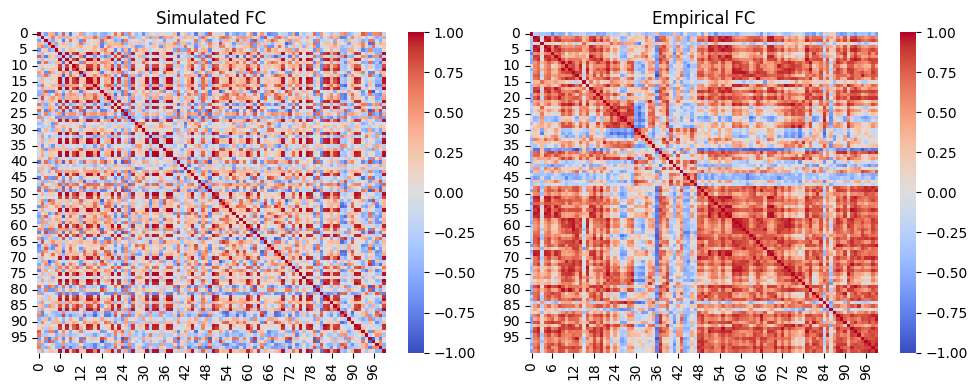

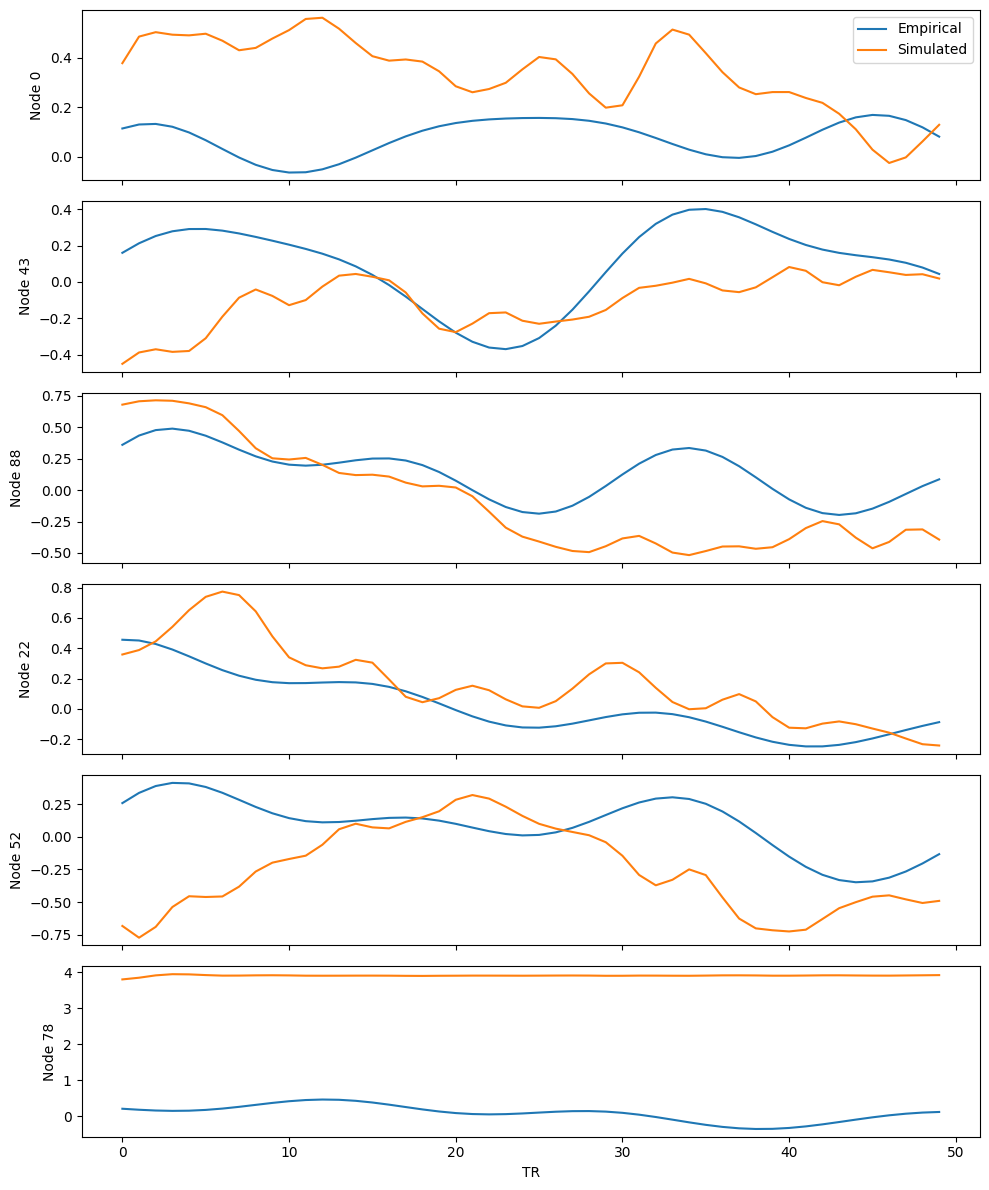

W_E 1.0027951002120972
W_I 0.7019111514091492
I_0 0.3227410912513733
tau_E 99.9995346069336
tau_I 9.997220039367676
gamma_E 0.004641617648303509
gamma_I 0.003179190680384636
sigma_E 0.016430646181106567
sigma_I 0.017223939299583435
sigma_BOLD 0.00038222019793465734
aE 310.00396728515625
bE 124.9972152709961
dE 0.1630667895078659
aI 615.001708984375
bI 176.99810791015625
dI 0.08448205143213272
g 30.003904342651367
g_EE 2.503533363342285
g_IE 0.4167417287826538
g_EI 0.4199163317680359
tau_s 0.9021867513656616
tau_f 0.4113333821296692
tau_0 0.9772639274597168
alpha 0.31685760617256165
rho 0.3363100290298462
k1 2.377514362335205
k2 2.002469301223755
k3 0.47760170698165894
V 0.02228780835866928
E0 0.338395357131958


Epochs [2/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.2592  I=0.0802  x=-0.0549  f=1.1326  v=1.0437  q=0.9799
TR 10 | E=0.2528  I=0.0900  x=-0.0003  f=1.1049  v=1.0306  q=0.9555
TR 20 | E=0.2480  I=0.0875  x=-0.0001  f=1.1020  v=1.0297  q=0.9564
TR 30 | E=0.2422  I=0.0872  x=-0.0003  f=1.0998  v=1.0290  q=0.9574
TR 40 | E=0.2411  I=0.0867  x=-0.0001  f=1.0993  v=1.0289  q=0.9579


Epoch 2/10 | Loss: 0.6982 | RMSE: 2.5746 | ROI Corr: 0.0073 | FC Corr: -0.0051


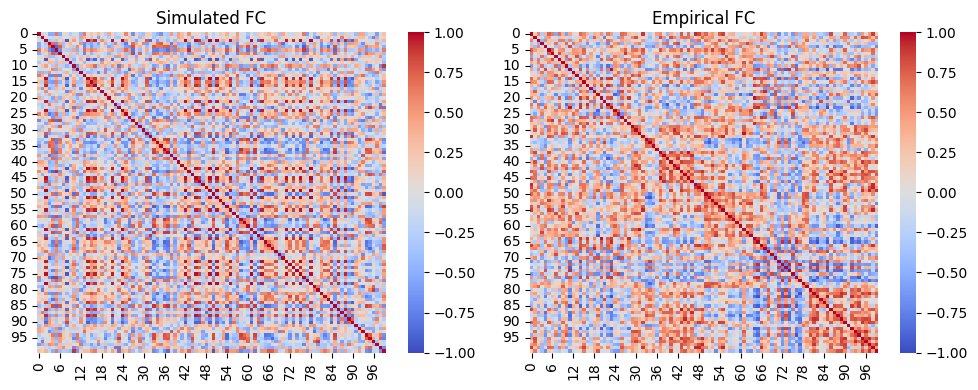

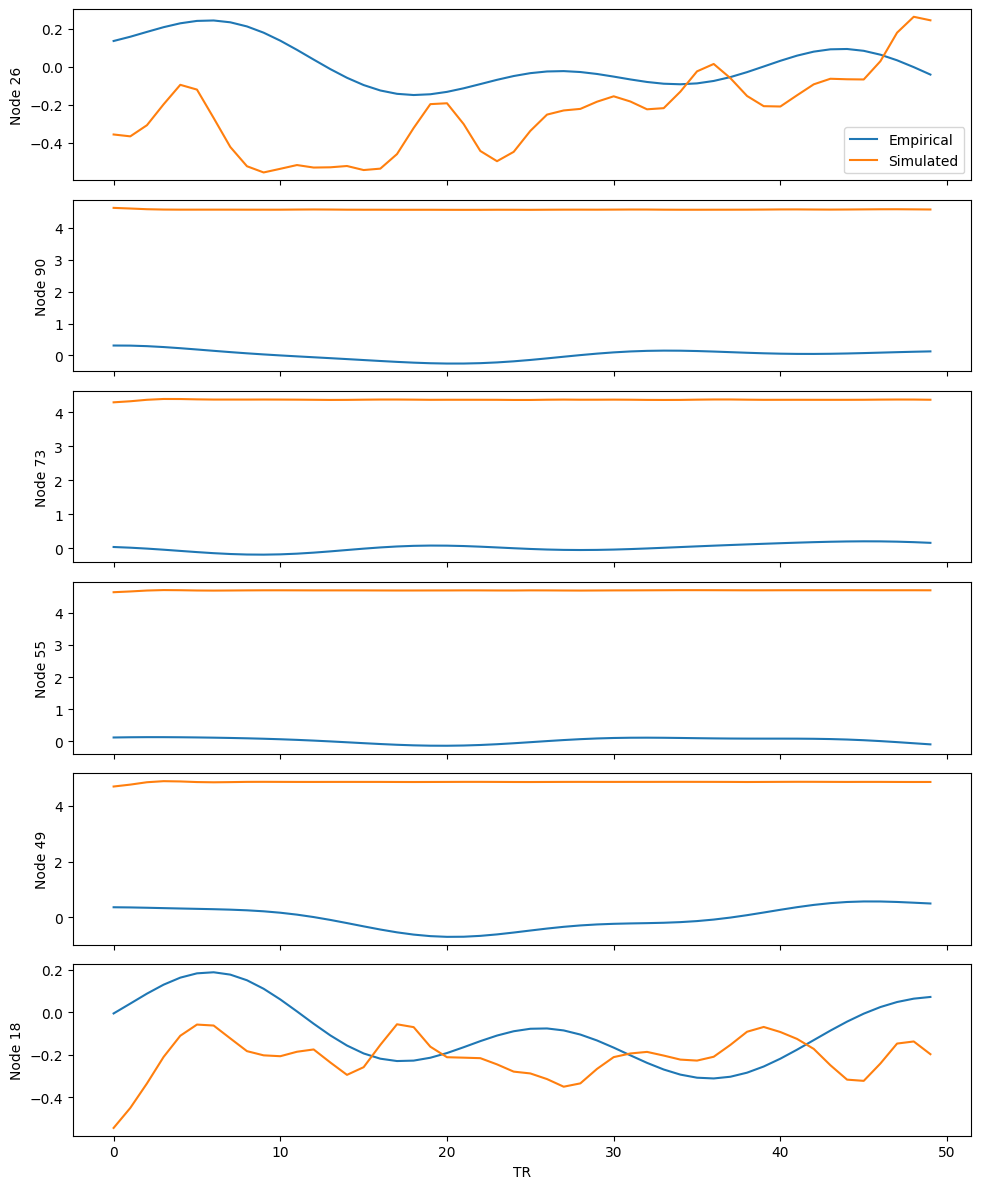

W_E 1.0060474872589111
W_I 0.6995331645011902
I_0 0.32594960927963257
tau_E 100.0016860961914
tau_I 9.994812965393066
gamma_E 0.007889460772275925
gamma_I 0.0014215183909982443
sigma_E 0.017398135736584663
sigma_I 0.014889398589730263
sigma_BOLD 0.0008476441726088524
aE 310.0074157714844
bE 124.99397277832031
dE 0.16141773760318756
aI 614.9992065429688
bI 177.00045776367188
dI 0.0863046944141388
g 30.005340576171875
g_EE 2.5070648193359375
g_IE 0.41339609026908875
g_EI 0.4165310859680176
tau_s 0.9022061824798584
tau_f 0.41346102952957153
tau_0 0.9790319800376892
alpha 0.3182029724121094
rho 0.3343068063259125
k1 2.3790981769561768
k2 2.0008113384246826
k3 0.4793989956378937
V 0.0233687125146389
E0 0.3372356593608856


Epochs [3/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.2912  I=0.0709  x=-0.0367  f=1.1415  v=1.0452  q=0.9795
TR 10 | E=0.2831  I=0.0833  x=-0.0002  f=1.1176  v=1.0342  q=0.9506
TR 20 | E=0.2780  I=0.0795  x=-0.0002  f=1.1150  v=1.0334  q=0.9515
TR 30 | E=0.2741  I=0.0780  x=-0.0001  f=1.1136  v=1.0329  q=0.9524
TR 40 | E=0.2700  I=0.0778  x=-0.0002  f=1.1116  v=1.0323  q=0.9533


Epoch 3/10 | Loss: 0.6978 | RMSE: 2.8548 | ROI Corr: 0.0067 | FC Corr: -0.0047


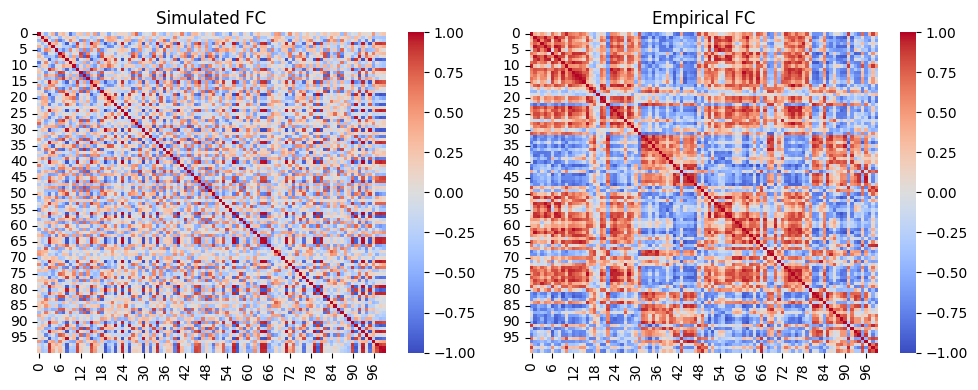

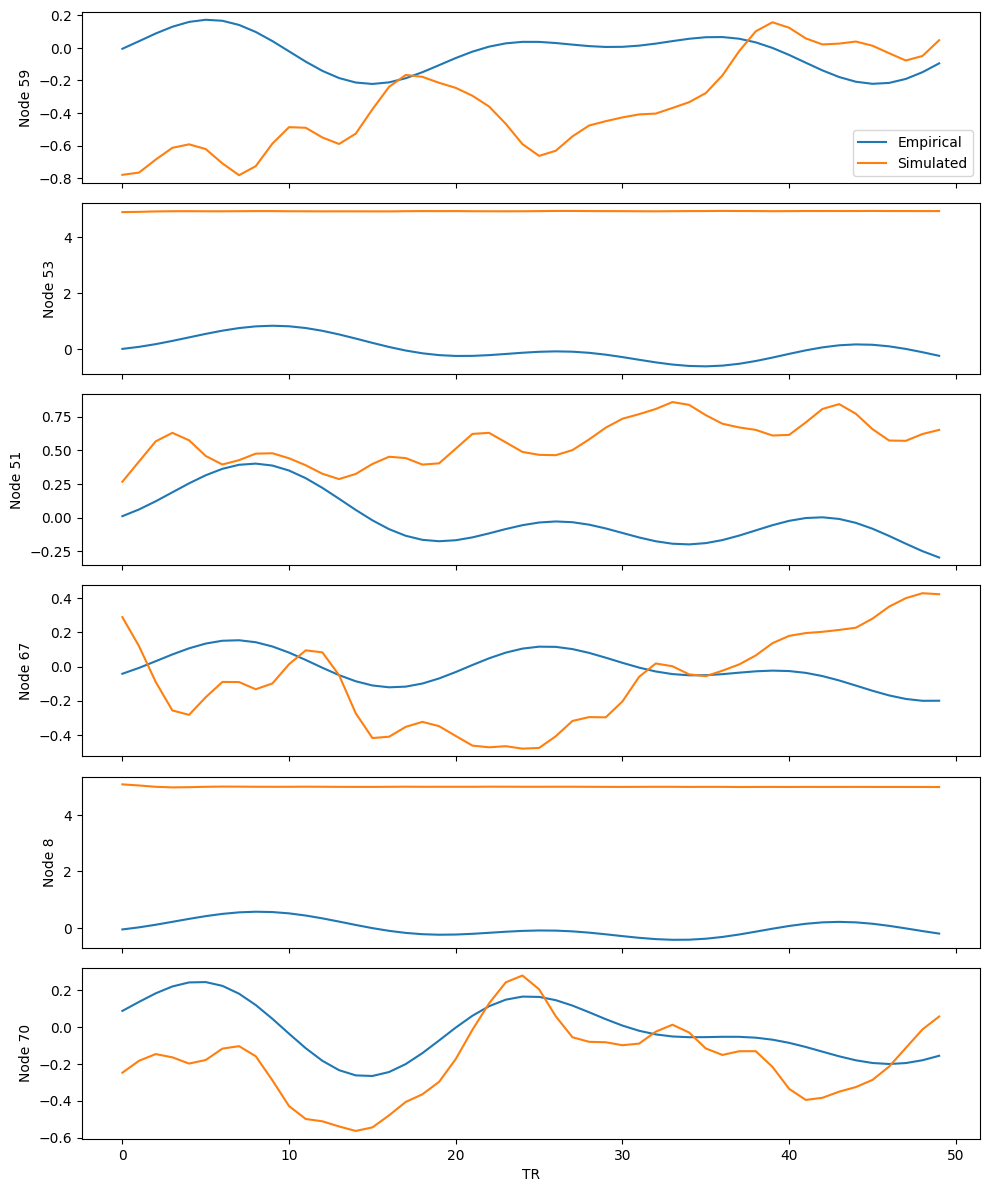

W_E 1.0081853866577148
W_I 0.6982944011688232
I_0 0.32816174626350403
tau_E 100.00277709960938
tau_I 9.993550300598145
gamma_E 0.009409653022885323
gamma_I 0.001955630723387003
sigma_E 0.017216328531503677
sigma_I 0.012509763240814209
sigma_BOLD 0.0006344388239085674
aE 310.0083923339844
bE 124.99183654785156
dE 0.16056489944458008
aI 614.9981079101562
bI 177.00169372558594
dI 0.0874517560005188
g 30.005224227905273
g_EE 2.508683681488037
g_IE 0.4112999439239502
g_EI 0.41520628333091736
tau_s 0.899927020072937
tau_f 0.4130837917327881
tau_0 0.9805399775505066
alpha 0.3198314905166626
rho 0.33480125665664673
k1 2.3812549114227295
k2 1.9987119436264038
k3 0.4816093146800995
V 0.02422350086271763
E0 0.33635690808296204


Epochs [4/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3104  I=0.0824  x=-0.0270  f=1.1459  v=1.0460  q=0.9799
TR 10 | E=0.3026  I=0.0926  x=0.0002  f=1.1253  v=1.0365  q=0.9477
TR 20 | E=0.2971  I=0.0894  x=-0.0002  f=1.1227  v=1.0357  q=0.9487
TR 30 | E=0.2927  I=0.0883  x=-0.0000  f=1.1208  v=1.0351  q=0.9497
TR 40 | E=0.2913  I=0.0879  x=0.0000  f=1.1203  v=1.0349  q=0.9501


Epoch 4/10 | Loss: 0.6945 | RMSE: 3.0965 | ROI Corr: 0.0052 | FC Corr: -0.0014


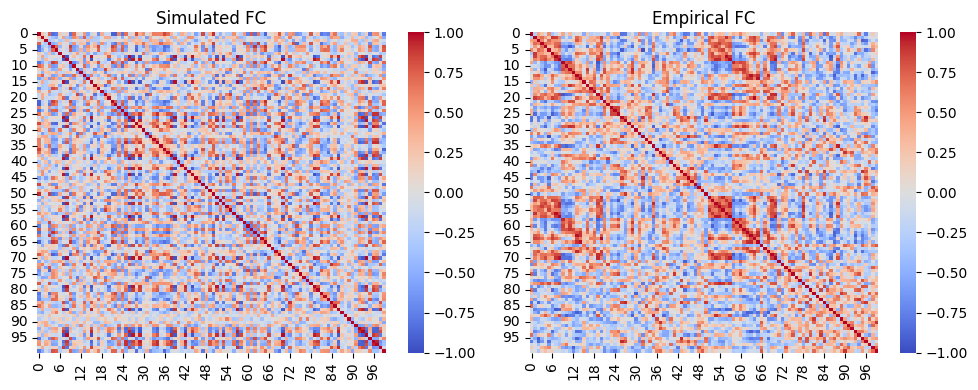

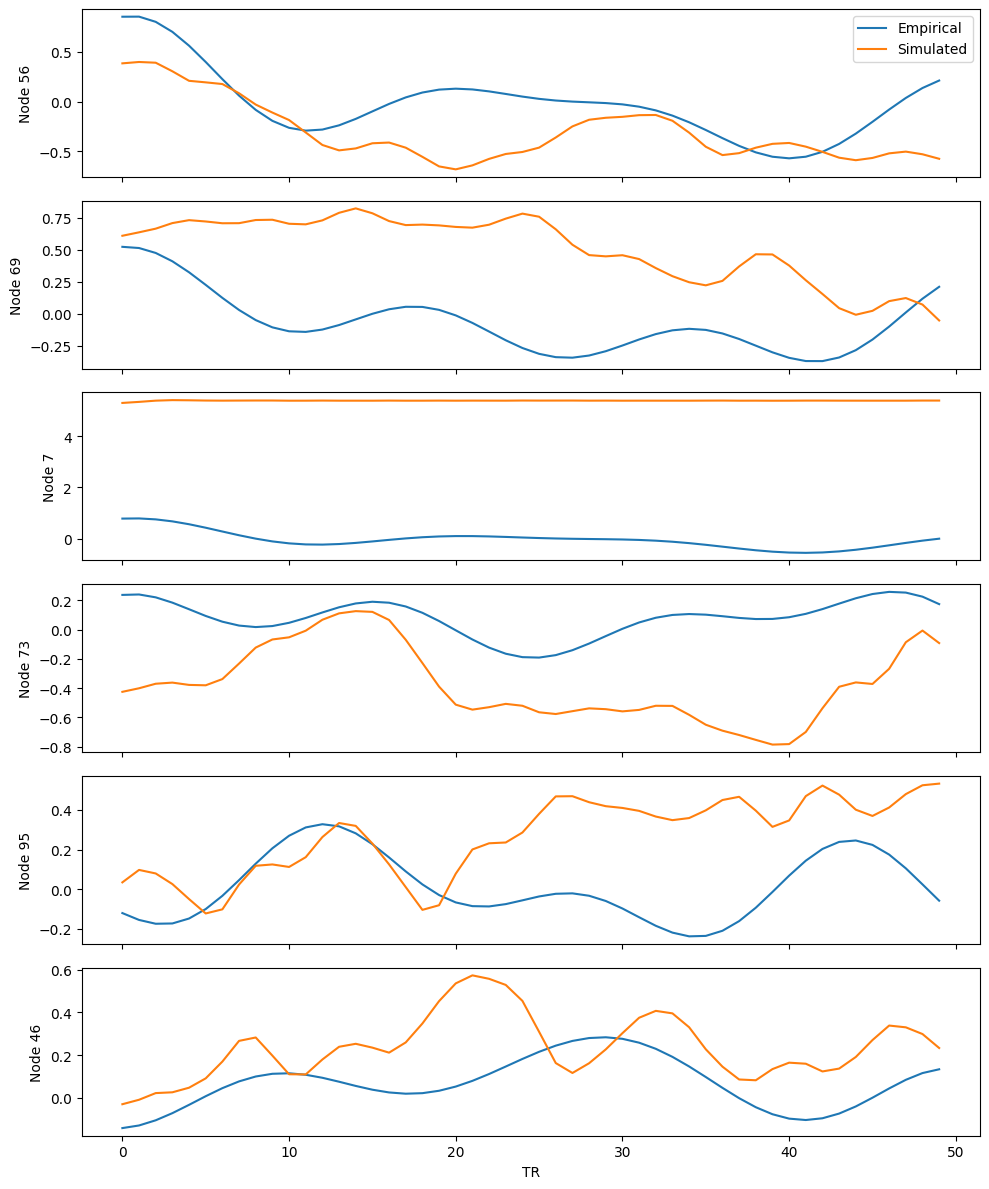

W_E 1.0098638534545898
W_I 0.6980143785476685
I_0 0.329932302236557
tau_E 100.00271606445312
tau_I 9.993138313293457
gamma_E 0.00954770389944315
gamma_I 0.003545355750247836
sigma_E 0.01644461788237095
sigma_I 0.010915030725300312
sigma_BOLD -0.0020161685533821583
aE 310.0079040527344
bE 124.99015045166016
dE 0.15961448848247528
aI 614.998046875
bI 177.00196838378906
dI 0.088132843375206
g 30.0041561126709
g_EE 2.5089032649993896
g_IE 0.40965956449508667
g_EI 0.4152822494506836
tau_s 0.8976742625236511
tau_f 0.4119325578212738
tau_0 0.9811872839927673
alpha 0.32071012258529663
rho 0.3359241783618927
k1 2.3814518451690674
k2 1.9985624551773071
k3 0.4820447862148285
V 0.025243135169148445
E0 0.3353671133518219


Epochs [5/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3079  I=0.0988  x=-0.0279  f=1.1449  v=1.0459  q=0.9801
TR 10 | E=0.2991  I=0.1034  x=0.0000  f=1.1235  v=1.0361  q=0.9486
TR 20 | E=0.2940  I=0.1001  x=-0.0003  f=1.1212  v=1.0354  q=0.9493
TR 30 | E=0.2902  I=0.0996  x=-0.0002  f=1.1195  v=1.0349  q=0.9502
TR 40 | E=0.2880  I=0.0992  x=-0.0003  f=1.1188  v=1.0347  q=0.9506


Epoch 5/10 | Loss: 0.6967 | RMSE: 3.1168 | ROI Corr: 0.0062 | FC Corr: -0.0036


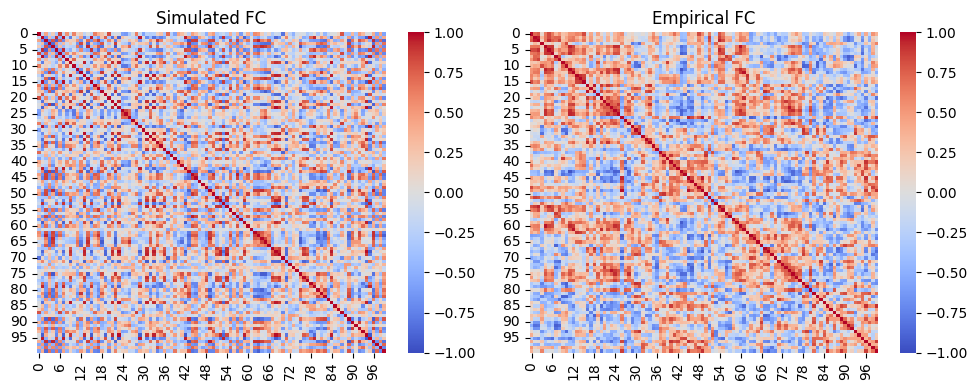

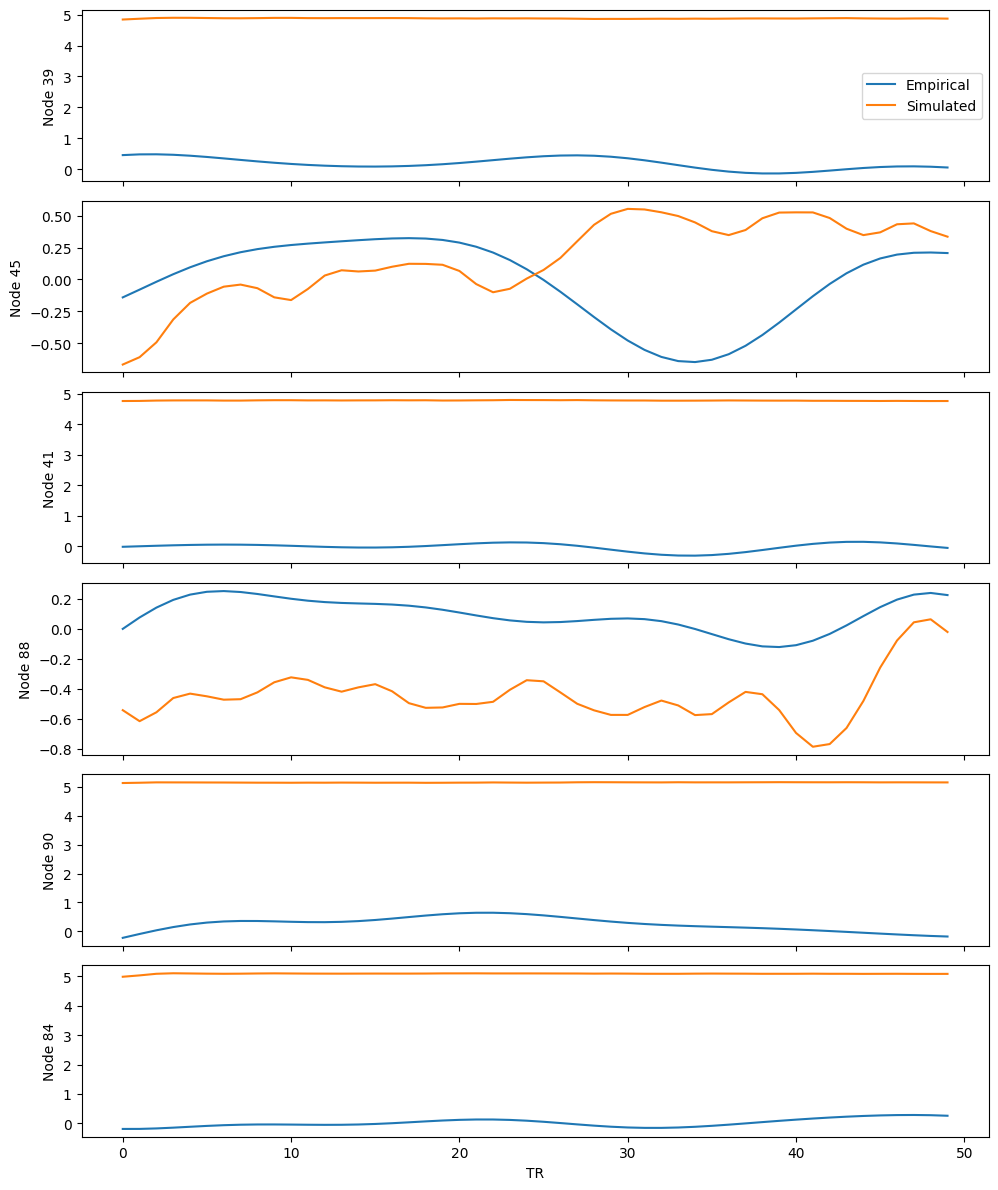

W_E 1.0122690200805664
W_I 0.6971681118011475
I_0 0.3323535919189453
tau_E 100.00247192382812
tau_I 9.992650985717773
gamma_E 0.010585170239210129
gamma_I 0.004368900321424007
sigma_E 0.015396571718156338
sigma_I 0.010021504946053028
sigma_BOLD -0.0019833515398204327
aE 310.0090026855469
bE 124.98776245117188
dE 0.1582067757844925
aI 614.9974365234375
bI 177.0028076171875
dI 0.08890397846698761
g 30.004865646362305
g_EE 2.509891986846924
g_IE 0.40802136063575745
g_EI 0.41459739208221436
tau_s 0.8951802253723145
tau_f 0.41278746724128723
tau_0 0.9816519618034363
alpha 0.32054537534713745
rho 0.3350900709629059
k1 2.3821499347686768
k2 1.9977220296859741
k3 0.483007550239563
V 0.02509729005396366
E0 0.33557629585266113


Epochs [6/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3176  I=0.1069  x=-0.0240  f=1.1481  v=1.0466  q=0.9790
TR 10 | E=0.3075  I=0.1098  x=-0.0003  f=1.1276  v=1.0372  q=0.9469
TR 20 | E=0.3014  I=0.1070  x=-0.0003  f=1.1244  v=1.0363  q=0.9481
TR 30 | E=0.2992  I=0.1063  x=-0.0003  f=1.1236  v=1.0360  q=0.9486
TR 40 | E=0.2966  I=0.1056  x=-0.0000  f=1.1224  v=1.0356  q=0.9493


Epoch 6/10 | Loss: 0.6986 | RMSE: 3.1926 | ROI Corr: 0.0026 | FC Corr: -0.0054


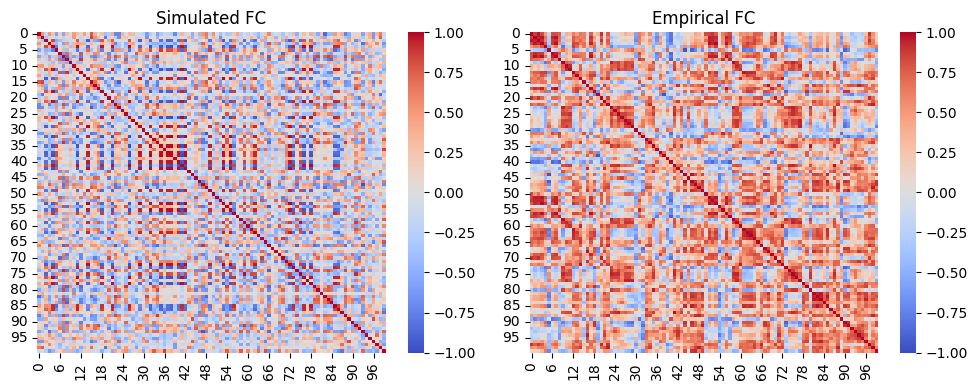

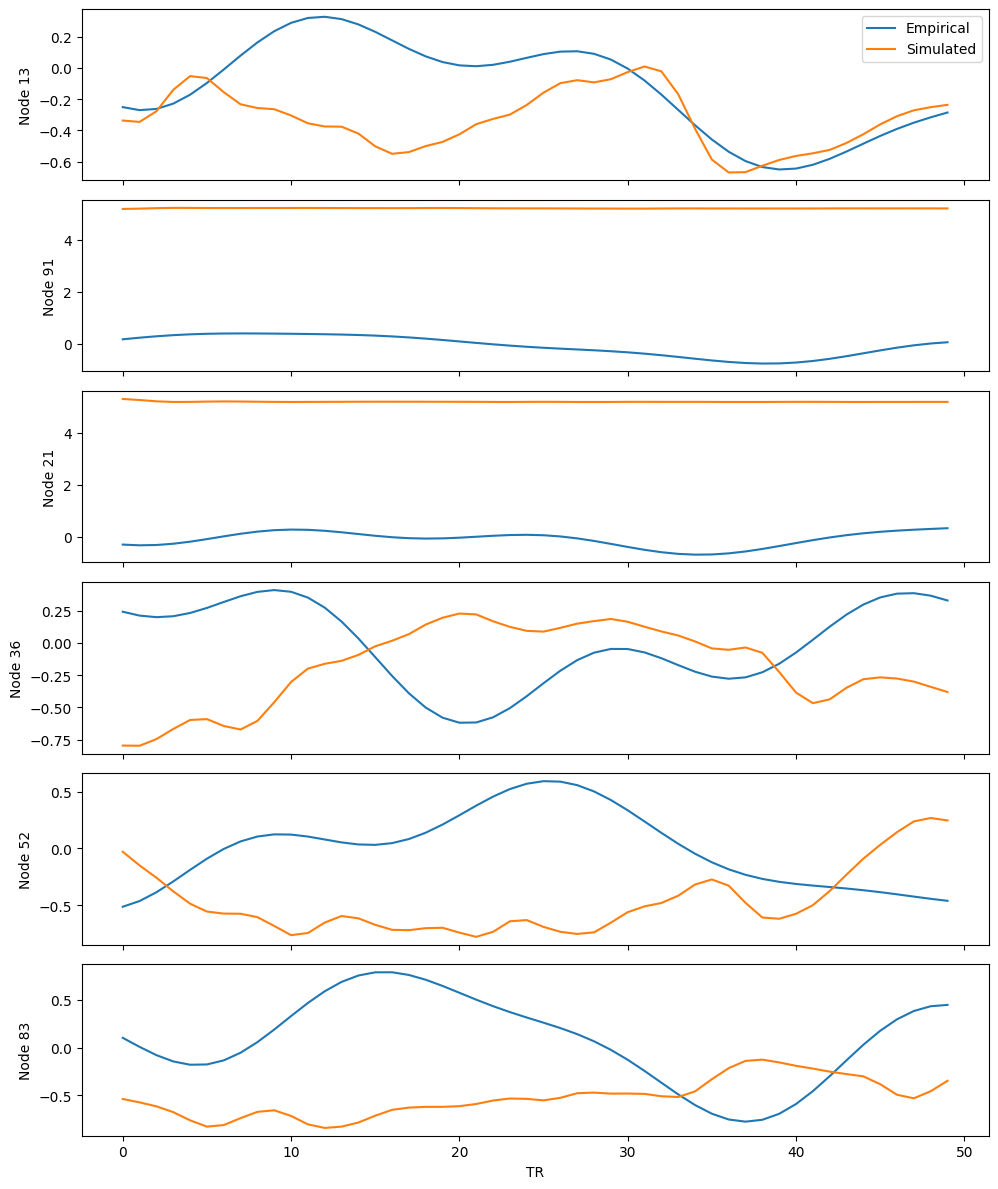

W_E 1.0143095254898071
W_I 0.6965607404708862
I_0 0.33442163467407227
tau_E 100.00212097167969
tau_I 9.992361068725586
gamma_E 0.010859217494726181
gamma_I 0.0049656229093670845
sigma_E 0.014234182424843311
sigma_I 0.009615370072424412
sigma_BOLD -0.0002309265692019835
aE 310.0091857910156
bE 124.98573303222656
dE 0.15672382712364197
aI 614.9970092773438
bI 177.00340270996094
dI 0.08969254046678543
g 30.00474739074707
g_EE 2.5101451873779297
g_IE 0.407073438167572
g_EI 0.4146105647087097
tau_s 0.8926469087600708
tau_f 0.4128135144710541
tau_0 0.9823029041290283
alpha 0.3209696412086487
rho 0.334806352853775
k1 2.3832051753997803
k2 1.9966533184051514
k3 0.4842963218688965
V 0.025535989552736282
E0 0.3351640999317169


Epochs [7/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3298  I=0.1128  x=-0.0180  f=1.1494  v=1.0467  q=0.9802
TR 10 | E=0.3204  I=0.1155  x=-0.0002  f=1.1326  v=1.0388  q=0.9447
TR 20 | E=0.3156  I=0.1131  x=-0.0004  f=1.1304  v=1.0381  q=0.9456
TR 30 | E=0.3111  I=0.1125  x=-0.0002  f=1.1285  v=1.0375  q=0.9466
TR 40 | E=0.3090  I=0.1117  x=-0.0001  f=1.1275  v=1.0371  q=0.9472


Epoch 7/10 | Loss: 0.6938 | RMSE: 3.3288 | ROI Corr: -0.0012 | FC Corr: -0.0007


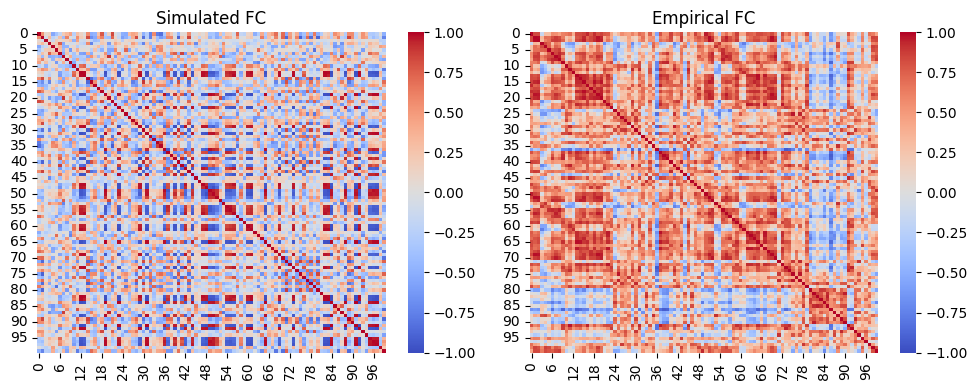

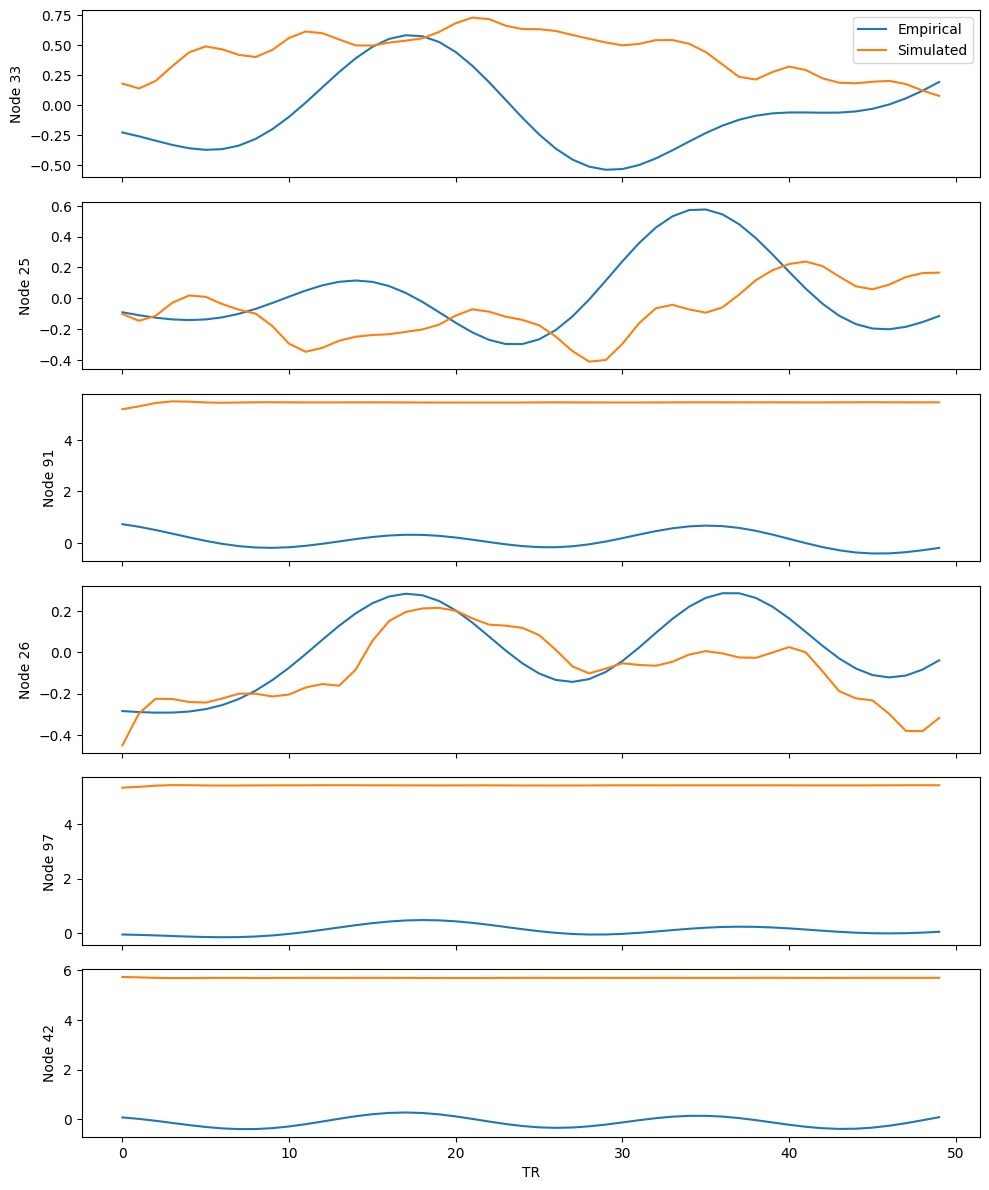

W_E 1.0148191452026367
W_I 0.6959941387176514
I_0 0.3348986506462097
tau_E 100.00155639648438
tau_I 9.992202758789062
gamma_E 0.011452975682914257
gamma_I 0.005319312214851379
sigma_E 0.011613629758358002
sigma_I 0.009266357868909836
sigma_BOLD -0.00024222288629971445
aE 310.0097351074219
bE 124.98521423339844
dE 0.15592798590660095
aI 614.9964599609375
bI 177.0039520263672
dI 0.09012934565544128
g 30.005172729492188
g_EE 2.510687828063965
g_IE 0.40635260939598083
g_EI 0.41418617963790894
tau_s 0.8900759816169739
tau_f 0.41320985555648804
tau_0 0.9823477268218994
alpha 0.32027187943458557
rho 0.33421191573143005
k1 2.384220838546753
k2 1.9956835508346558
k3 0.4855324625968933
V 0.026294711977243423
E0 0.3344096839427948


Epochs [8/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3214  I=0.1134  x=-0.0211  f=1.1490  v=1.0466  q=0.9798
TR 10 | E=0.3122  I=0.1139  x=0.0001  f=1.1294  v=1.0377  q=0.9462
TR 20 | E=0.3079  I=0.1118  x=-0.0003  f=1.1273  v=1.0371  q=0.9468
TR 30 | E=0.3047  I=0.1114  x=-0.0001  f=1.1259  v=1.0366  q=0.9476
TR 40 | E=0.3021  I=0.1108  x=-0.0002  f=1.1248  v=1.0363  q=0.9481


Epoch 8/10 | Loss: 0.6962 | RMSE: 3.3976 | ROI Corr: 0.0086 | FC Corr: -0.0031


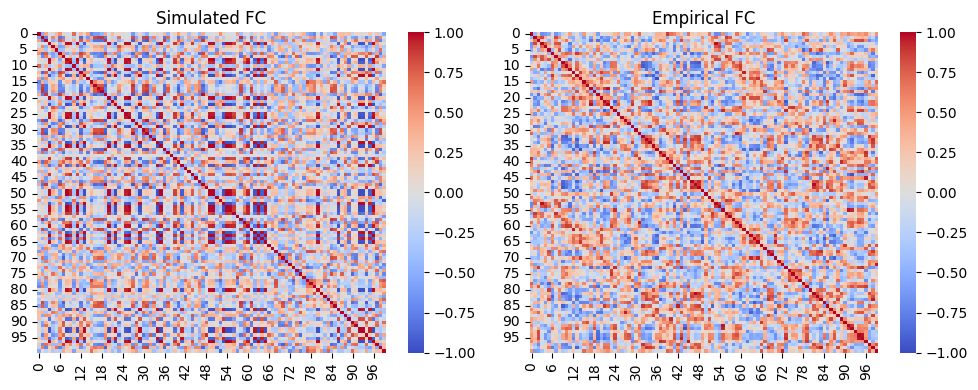

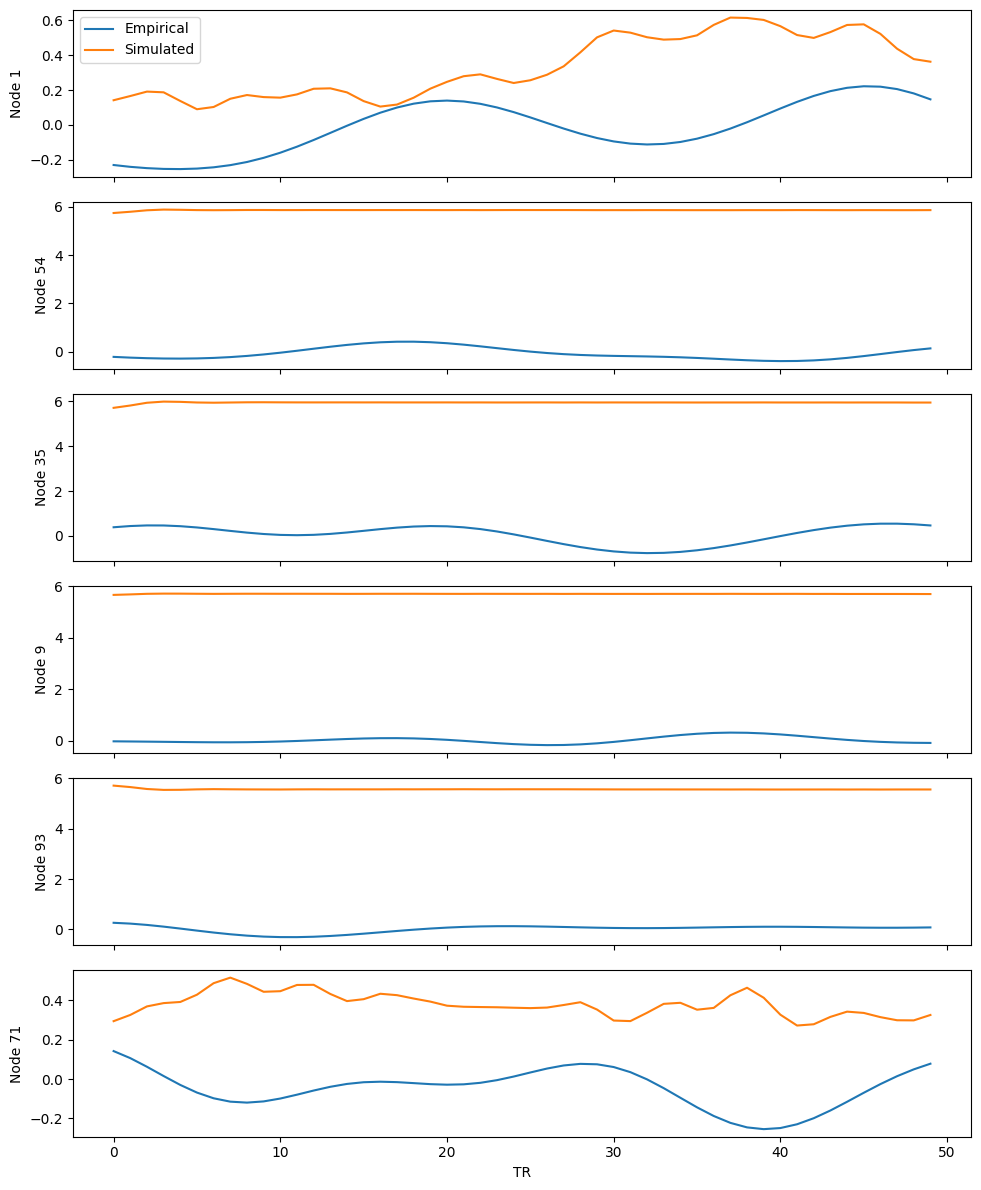

W_E 1.0148415565490723
W_I 0.6952009201049805
I_0 0.334846556186676
tau_E 100.00064849853516
tau_I 9.991868019104004
gamma_E 0.012065278366208076
gamma_I 0.0055211992003023624
sigma_E 0.008900848217308521
sigma_I 0.008849564008414745
sigma_BOLD -0.0012239565839990973
aE 310.0102844238281
bE 124.98517608642578
dE 0.15501679480075836
aI 614.9959106445312
bI 177.0047149658203
dI 0.09097142517566681
g 30.005760192871094
g_EE 2.5110244750976562
g_IE 0.40641358494758606
g_EI 0.4139660596847534
tau_s 0.886894702911377
tau_f 0.4138115346431732
tau_0 0.9822384119033813
alpha 0.3191702365875244
rho 0.3334057927131653
k1 2.384060859680176
k2 1.9957828521728516
k3 0.48572269082069397
V 0.026789816096425056
E0 0.3339206874370575


Epochs [9/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3445  I=0.1199  x=-0.0115  f=1.1529  v=1.0470  q=0.9794
TR 10 | E=0.3362  I=0.1207  x=-0.0002  f=1.1394  v=1.0405  q=0.9417
TR 20 | E=0.3317  I=0.1182  x=-0.0002  f=1.1375  v=1.0399  q=0.9426
TR 30 | E=0.3295  I=0.1174  x=-0.0002  f=1.1364  v=1.0395  q=0.9432
TR 40 | E=0.3271  I=0.1172  x=-0.0001  f=1.1353  v=1.0392  q=0.9436


Epoch 9/10 | Loss: 0.6964 | RMSE: 3.5701 | ROI Corr: 0.0017 | FC Corr: -0.0032


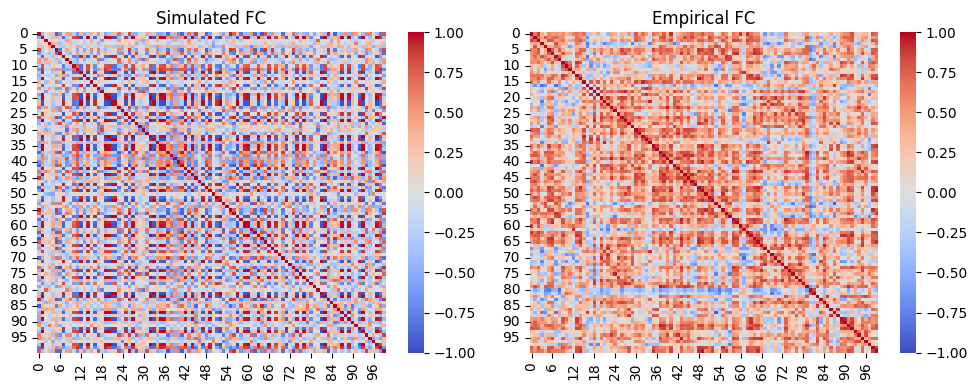

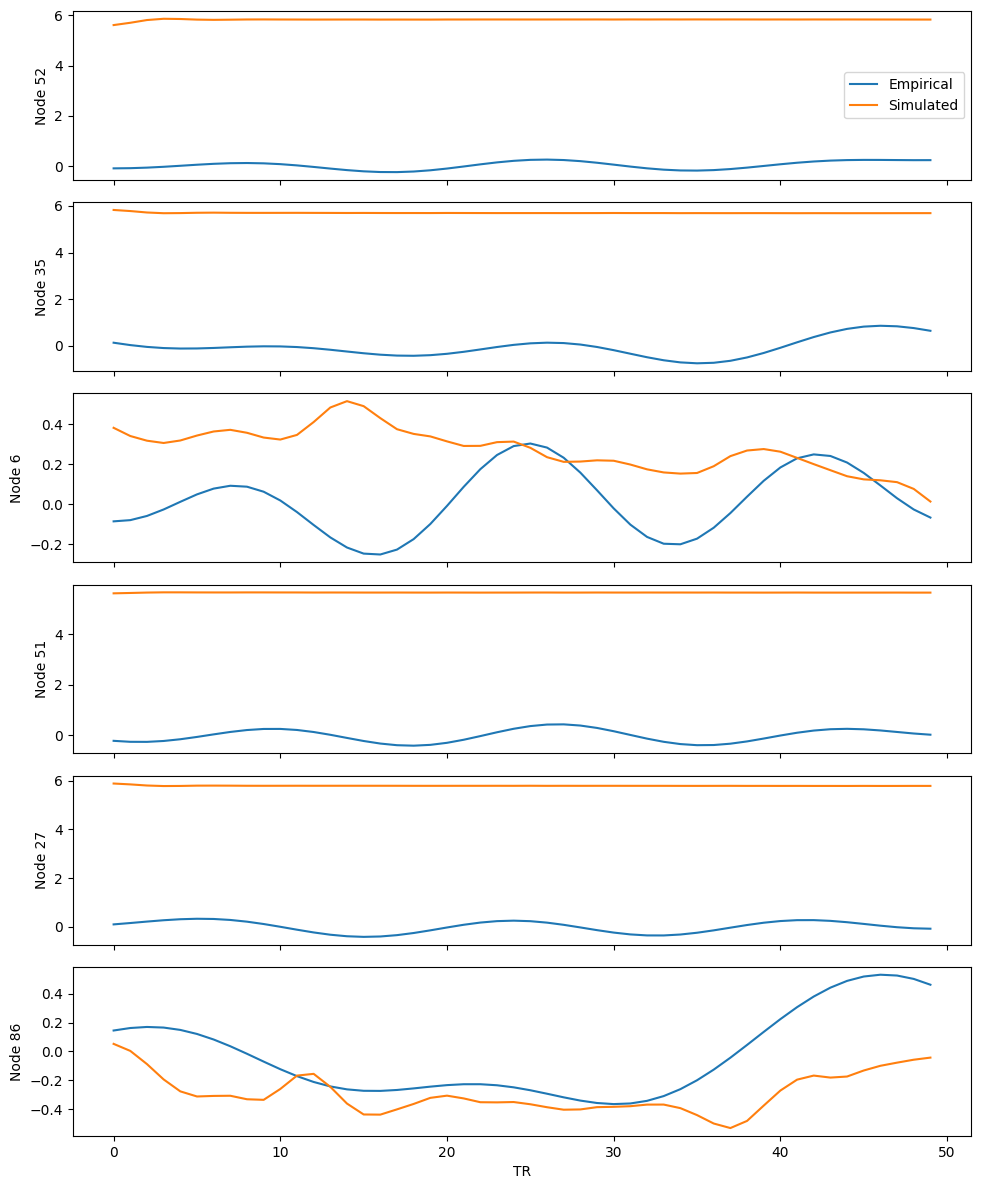

W_E 1.0159049034118652
W_I 0.694737434387207
I_0 0.33590149879455566
tau_E 100.00031280517578
tau_I 9.991619110107422
gamma_E 0.011846179142594337
gamma_I 0.00570002431049943
sigma_E 0.007174595724791288
sigma_I 0.008695063181221485
sigma_BOLD -0.0011256261495873332
aE 310.010009765625
bE 124.9841079711914
dE 0.15412648022174835
aI 614.9956665039062
bI 177.00515747070312
dI 0.09168130159378052
g 30.005178451538086
g_EE 2.5111873149871826
g_IE 0.4059291481971741
g_EI 0.4141703248023987
tau_s 0.8844175338745117
tau_f 0.4131248891353607
tau_0 0.982764720916748
alpha 0.31962764263153076
rho 0.3338441848754883
k1 2.384253740310669
k2 1.9954851865768433
k3 0.4862147867679596
V 0.02693067491054535
E0 0.333802729845047


Epochs [10/10]:   0%|          | 0/4 [00:00<?, ?batch/s]

TR 00 | E=0.3267  I=0.1177  x=-0.0179  f=1.1498  v=1.0465  q=0.9800
TR 10 | E=0.3184  I=0.1162  x=0.0001  f=1.1318  v=1.0383  q=0.9451
TR 20 | E=0.3153  I=0.1141  x=-0.0001  f=1.1303  v=1.0379  q=0.9456
TR 30 | E=0.3124  I=0.1139  x=-0.0001  f=1.1291  v=1.0375  q=0.9462
TR 40 | E=0.3102  I=0.1130  x=-0.0001  f=1.1282  v=1.0372  q=0.9467


Epoch 10/10 | Loss: 0.6992 | RMSE: 3.4592 | ROI Corr: 0.0022 | FC Corr: -0.0060


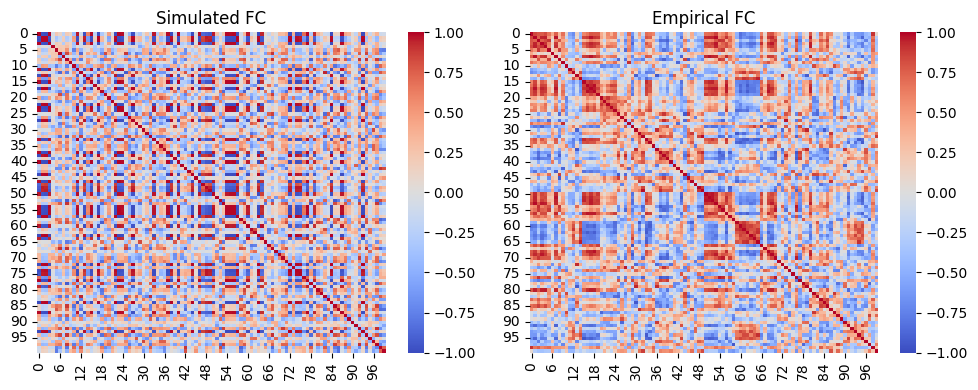

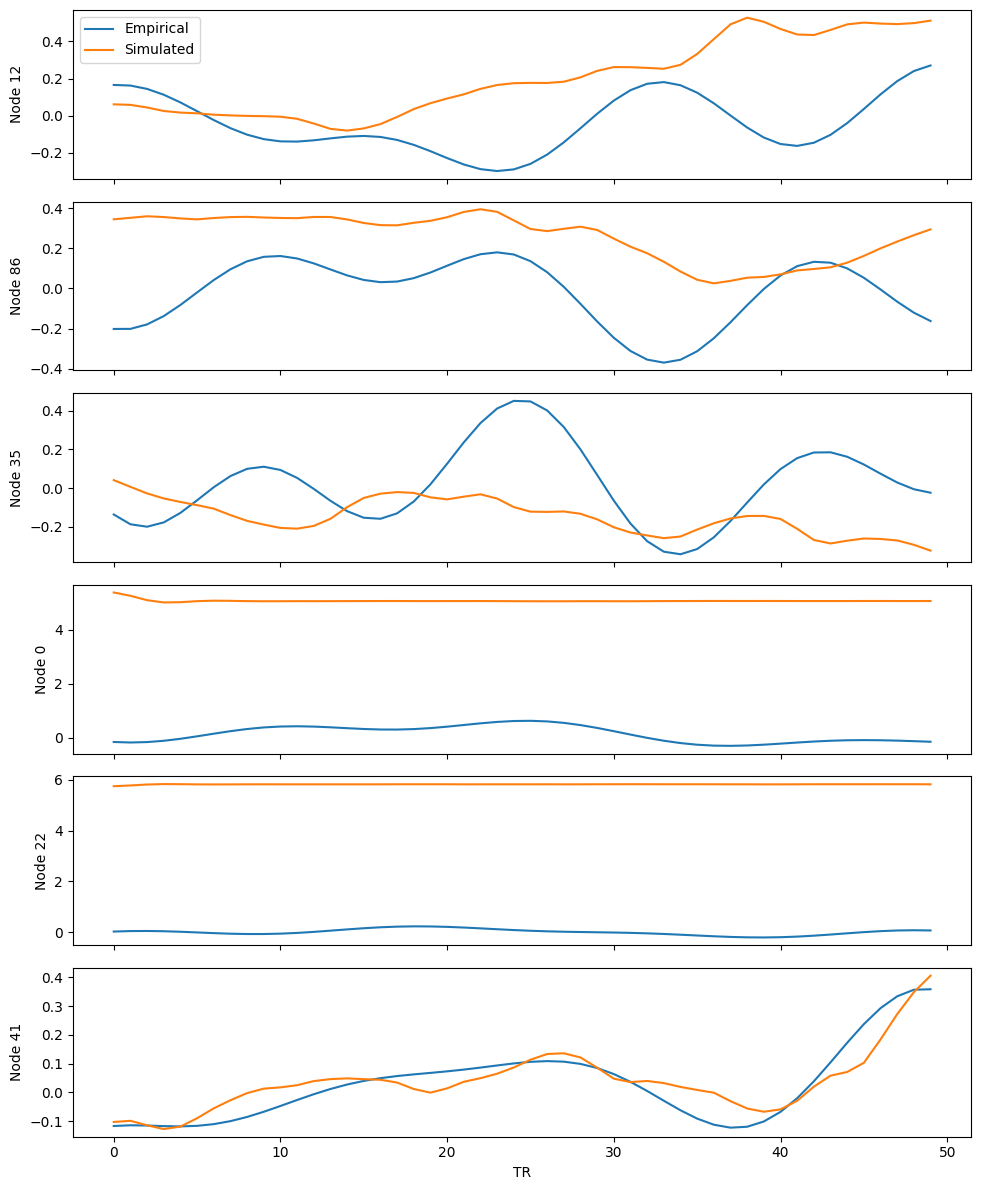

W_E 1.0157233476638794
W_I 0.6949561834335327
I_0 0.3357398808002472
tau_E 100.0010986328125
tau_I 9.99163818359375
gamma_E 0.011318041943013668
gamma_I 0.005945722106844187
sigma_E 0.005729240830987692
sigma_I 0.008912552148103714
sigma_BOLD -0.00095801567658782
aE 310.0092468261719
bE 124.9842758178711
dE 0.15413591265678406
aI 614.9959716796875
bI 177.00494384765625
dI 0.09196636080741882
g 30.004430770874023
g_EE 2.510612726211548
g_IE 0.40612074732780457
g_EI 0.41487279534339905
tau_s 0.8829683661460876
tau_f 0.41228073835372925
tau_0 0.9834758639335632
alpha 0.32066646218299866
rho 0.3342587351799011
k1 2.385037422180176
k2 1.9945544004440308
k3 0.48724365234375
V 0.026749223470687866
E0 0.3340241611003876


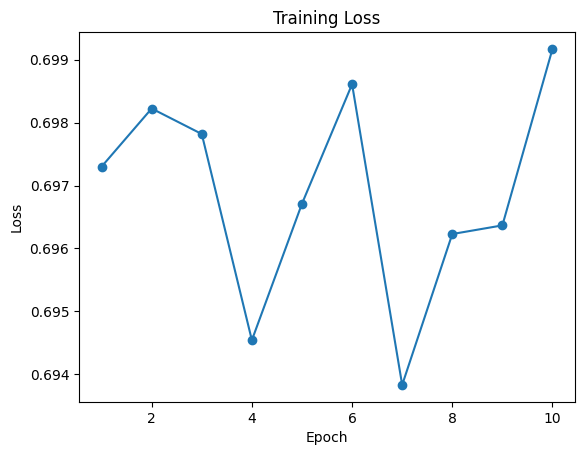

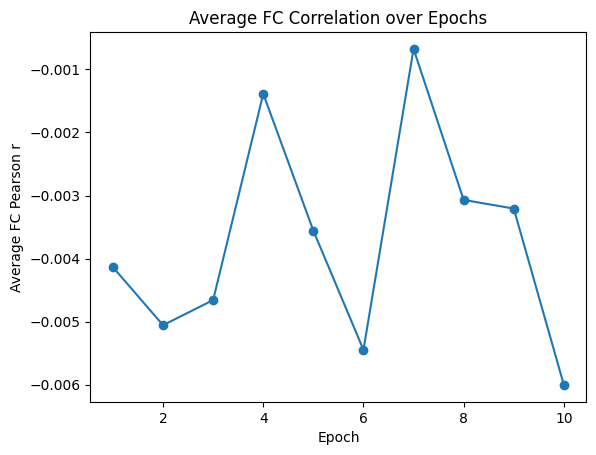

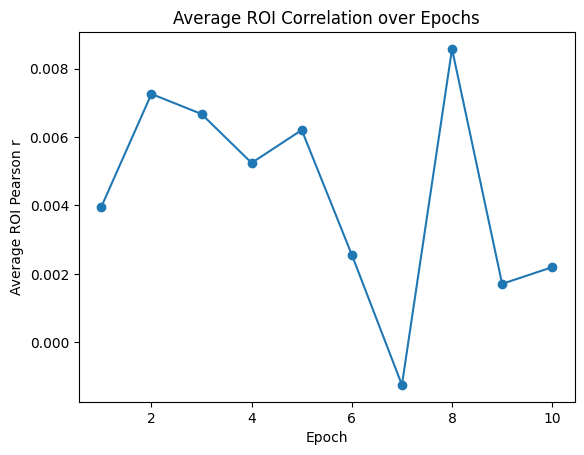

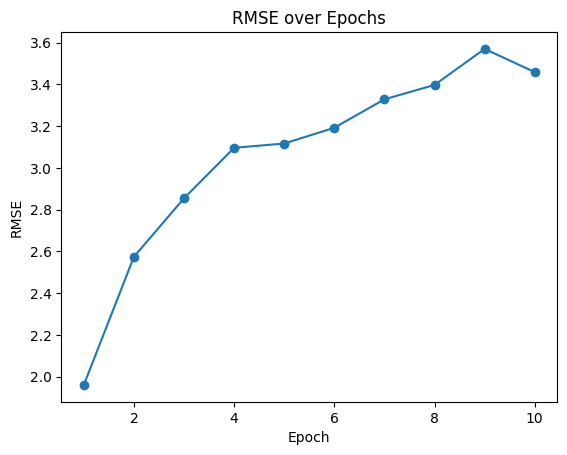

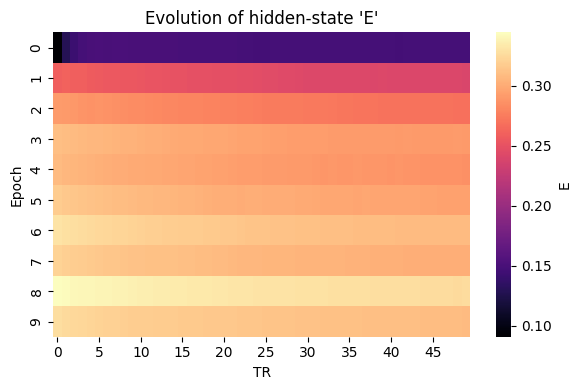

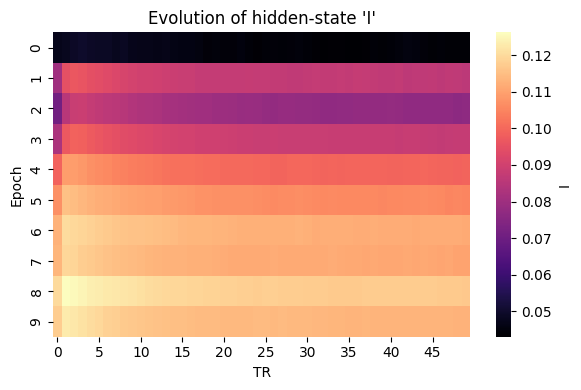

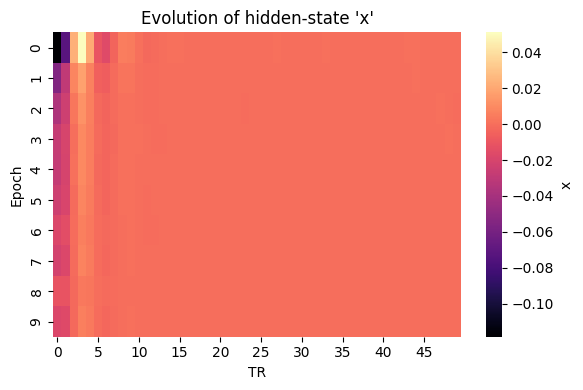

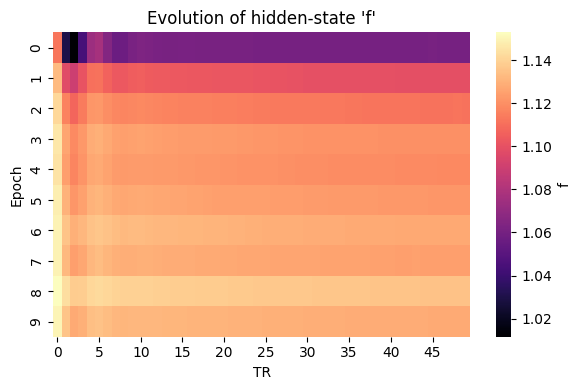

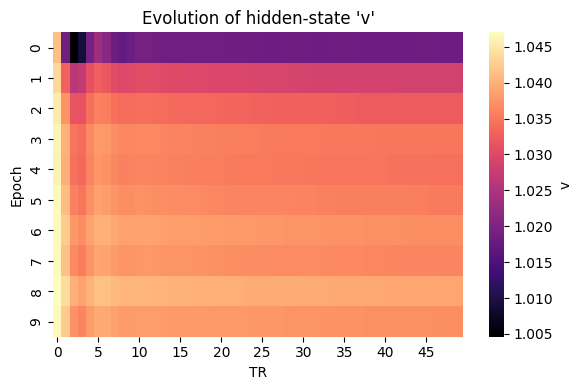

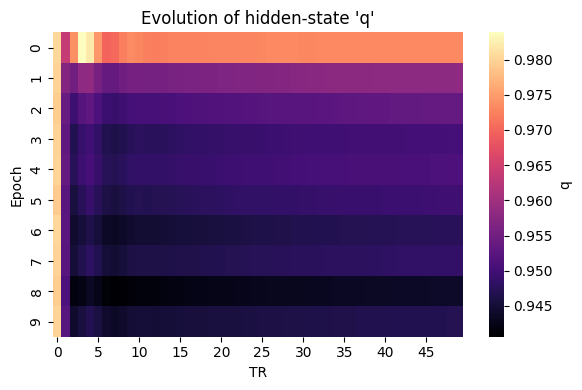

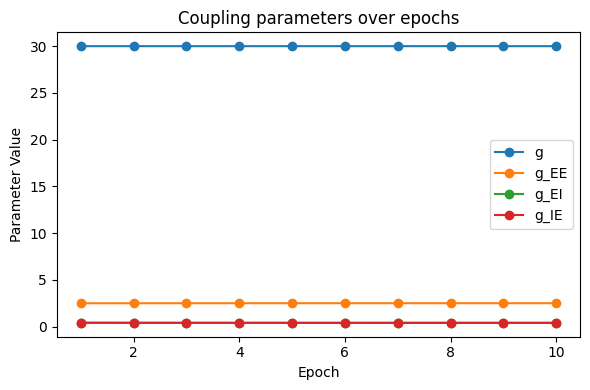

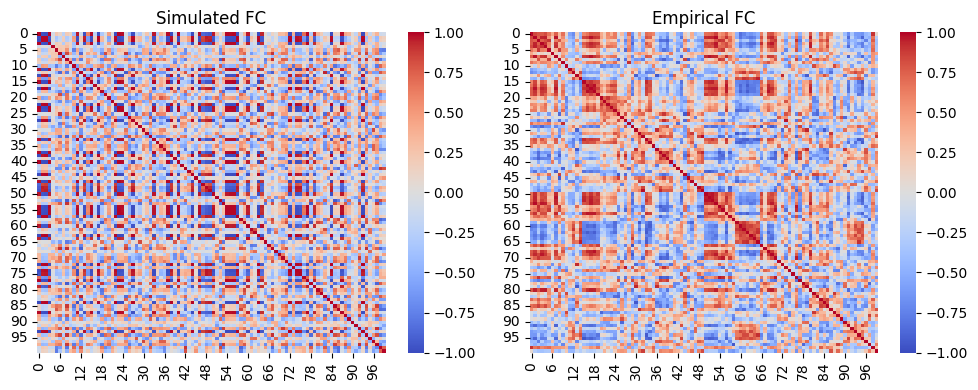

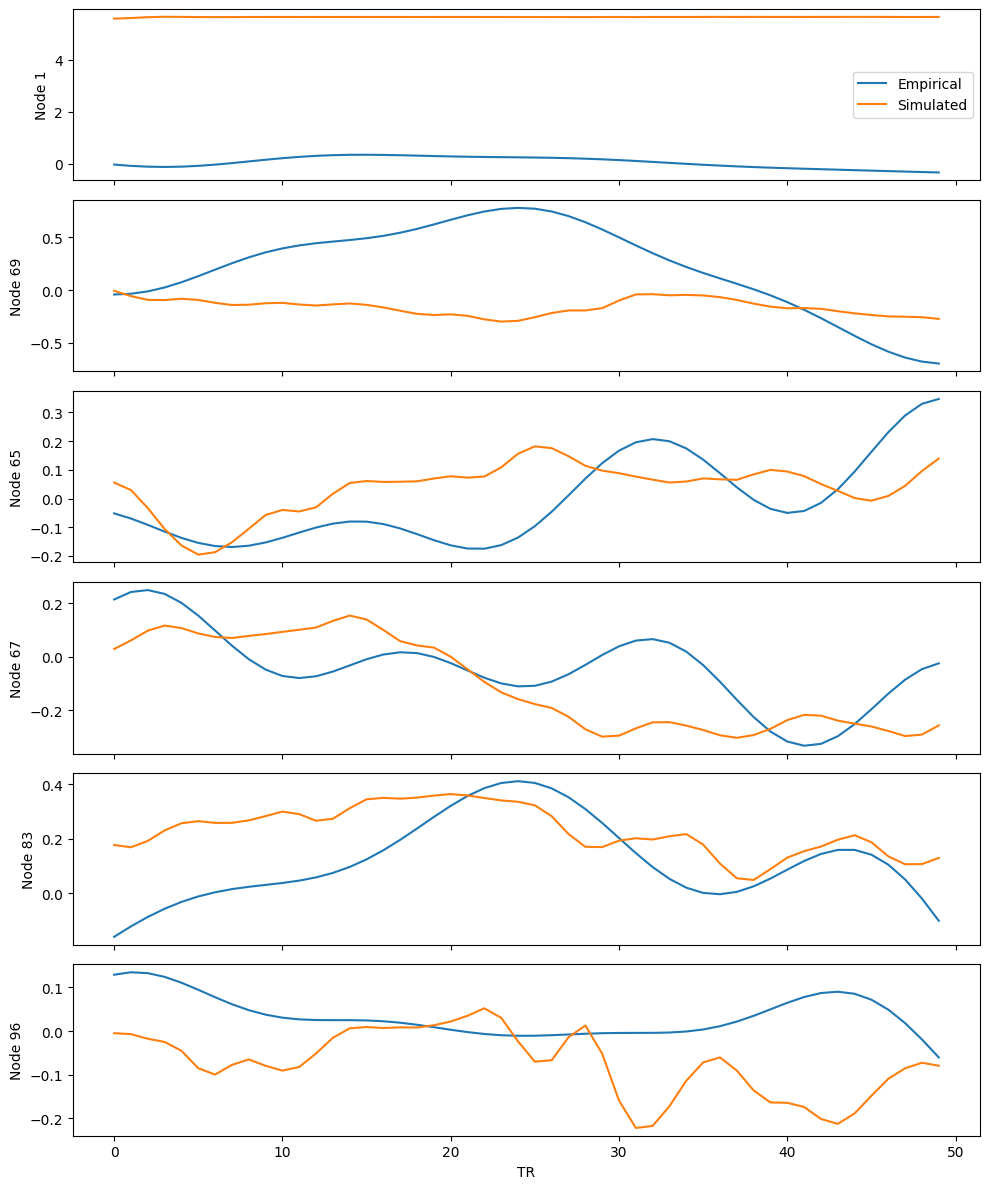

W_E 1.0157233476638794
W_I 0.6949561834335327
I_0 0.3357398808002472
tau_E 100.0010986328125
tau_I 9.99163818359375
gamma_E 0.011318041943013668
gamma_I 0.005945722106844187
sigma_E 0.005729240830987692
sigma_I 0.008912552148103714
sigma_BOLD -0.00095801567658782
aE 310.0092468261719
bE 124.9842758178711
dE 0.15413591265678406
aI 614.9959716796875
bI 177.00494384765625
dI 0.09196636080741882
g 30.004430770874023
g_EE 2.510612726211548
g_IE 0.40612074732780457
g_EI 0.41487279534339905
tau_s 0.8829683661460876
tau_f 0.41228073835372925
tau_0 0.9834758639335632
alpha 0.32066646218299866
rho 0.3342587351799011
k1 2.385037422180176
k2 1.9945544004440308
k3 0.48724365234375
V 0.026749223470687866
E0 0.3340241611003876
[Main] Training complete


In [101]:
trainer.train(delays_max, batch_size)

print("[Main] Training complete")


### Impulse Test

In [ ]:
@torch.no_grad()
def coupling_impulse_test(model, g_val, n_nodes=8, n_TR=100):
    """
    Stimulate node 0 with a single-TR pulse and plot mean E over time
    for the other nodes.  Run with g=0 and a large g to see the effect.
    """

    old_g = model.g.data.clone()
    model.g.data = g_val           # set global coupling
    print(f"g_val: {g_val}")

    B = 1
    state  = model.generate_initial_states()[:, :model.state_size, :B]
    delays = torch.zeros(model.node_size, model.delays_max, B)

    # external pulse: 1 at first hidden step for node 0
    external = torch.zeros(model.node_size, model.hidden_size, B)
    external[0, 0] = 1.0

    E_traj = []
    for _ in range(n_TR):
        noise_in  = torch.zeros(model.node_size, model.hidden_size,
                                model.input_size, B)
        noise_out = torch.zeros(model.node_size, B)
        state, _, delays = model(state, external, noise_in,
                                 noise_out, delays,
                                 batched_laplacian=torch.zeros(B, n_nodes, n_nodes),
                                 dist_matrices=torch.zeros(B, n_nodes, n_nodes))
        E_traj.append(state[:,0,:].squeeze())   # store E only
        external.zero_()   # pulse only on the first TR
    
    model.g.data.copy_(old_g)          # restore original g
    E_traj = torch.stack(E_traj, 1)    # (node, time)
    plt.plot(E_traj[0].cpu(), label='stim node')
    plt.plot(E_traj[1:].mean(0).cpu(), label='mean of others')
    plt.title(f'Impulse response, g={g_val}')
    plt.legend(); plt.xlabel('TR'); plt.ylabel('E')
    plt.show()

model = WholeBrainModel(params, input_size, 8, 1, step_size, tr, 20)

coupling_impulse_test(model, torch.tensor(0, dtype=torch.float32))


### Coupling Experiments

In [31]:
import copy

torch.manual_seed(0)

test_batch_size = 1
test_delays_max = 50
params = ModelParams()
model = WholeBrainModel(params, input_size, node_size, test_batch_size, step_size, tr, test_delays_max)
device = next(model.parameters()).device

_, laplacians, dist_matrices, _ = data_loader.sample_minibatch(test_batch_size)

model_coup = copy.deepcopy(model)
model_coup.g.data.fill_(400.)
model_noc  = copy.deepcopy(model)
model_noc.g.data.fill_(0.)

def run(model, laplacians, dist_matrices, device):
    print(f"[STARTING RUN] - g = {model.g.item()}, g_EE = {model.g_EE.item()}, sigma_E = {model.sigma_E.item()}, sigma_I = {model.sigma_I.item()}, sigma_BOLD = {model.sigma_BOLD.item()}")
    laplacians     = laplacians.to(device)
    dist_matrices  = dist_matrices.to(device)

    
    state = model.generate_initial_states().to(device)
    delays = torch.zeros(model.node_size, test_delays_max, test_batch_size)
    bold = []
    e = []
    for _ in range(100):
        noise_in  = torch.randn(node_size, model.hidden_size, input_size, test_batch_size, device=device)
        noise_out = torch.randn(node_size, test_batch_size, device=device)

        ext = torch.zeros(node_size, model.hidden_size, test_batch_size, device=device)
        state, y, delays = model(state, ext, noise_in, noise_out, delays, laplacians, dist_matrices)
        # print('SNR =', ((y - noise_out).std() / noise_out.std()).item())
        e.append(state[:, 0, :].detach().squeeze(1))
        print(state[:, 0, :].mean().item())
        bold.append(y.mean(1))
    return torch.stack(bold), torch.stack(e)

bold_400, e_400 = run(model_coup, laplacians, dist_matrices, device)
bold_0, e_0 = run(model_noc, laplacians, dist_matrices, device)

print('std bold (g=400):', bold_400.std().item(), 'std bold (g=0):', bold_0.std().item())
print('CORR BOLD       :', torch.corrcoef(bold_400.T).abs().mean().item(),
                             torch.corrcoef(bold_0.T).abs().mean().item())
print('CORR E          :', torch.corrcoef(e_400).abs().mean().item(),
                             torch.corrcoef(e_0).abs().mean().item())




[DEBUG] Model initialized with 6 states, 29 learnable parameters, and 15 hidden step size
[STARTING RUN] - g = 400.0, g_EE = 2.5, sigma_E = 0.019999999552965164, sigma_I = 0.019999999552965164, sigma_BOLD = 0.019999999552965164
0.34676799178123474
0.33873772621154785
0.3310260474681854
0.326227605342865
0.3212602734565735
0.3191368877887726
0.31693708896636963
0.3129013180732727
0.31192463636398315
0.31018397212028503
0.30846157670021057
0.3064529299736023
0.3059980273246765
0.3047659993171692
0.30457109212875366
0.305608332157135
0.304277241230011
0.3027627766132355
0.3024885952472687
0.30187851190567017
0.3003745973110199
0.2987288236618042
0.2978981137275696
0.298061728477478
0.2971906065940857
0.2967502474784851
0.30005285143852234
0.29807692766189575
0.2991199195384979
0.2994721233844757
0.30013370513916016
0.30186471343040466
0.3001541793346405
0.29975783824920654
0.2995337247848511
0.29842454195022583
0.2970705032348633
0.29795894026756287
0.2970106601715088
0.29881367087364197
